## Apprentissage par Transfert du CNN en utilisant VGG-16 Mis à Jour
Ce notebook a été mis à jour pour intégrer les chemins et la gestion des données du notebook SIFT, assurant une approche cohérente dans la gestion du jeu de données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir # Import de la fonction pour lister les fichiers dans un répertoire
from sklearn.model_selection import train_test_split # Import de la fonction pour diviser les données en ensembles d'apprentissage et de test
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve # Import des métriques d'évaluation
from glob import glob # Import de la fonction pour trouver des fichiers correspondant à un modèle de chemin

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential # Import des modèles séquentiels et fonctionnels qui permettent de définir un modèle de réseau neuronal
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout  # Import des couches de réseau neuronal
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom # Import des transformations d'images
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import des rappels pour le modèle
from tensorflow.keras.applications.vgg16 import VGG16 # Import du modèle VGG16 pré-entraîné
from tensorflow.keras.applications.vgg16 import preprocess_input # Import de la fonction pour prétraiter les images pour VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Import des fonctions pour charger et convertir les images
from tensorflow.keras.utils import to_categorical # Import de la fonction pour convertir les étiquettes en format catégoriel


## Chargement et Prétraitement des Données  
Ici, nous chargeons et prétraitons nos données d'images, en nous alignant sur les méthodes utilisées dans le notebook SIFT."

In [2]:
import pandas as pd
import os

# Définir le chemin relatif
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Charger le CSV dans un DataFrame
df = pd.read_csv(file_path)

# Afficher les premières lignes du df
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

### Import du dataset des images sous forme de fichiers jpg


Image: 009099b1f6e1e8f893ec29a7023153c4.jpg
 - Dimensions: (687, 1162)
 - Mode: RGB
------------------------------
Image: 0096e89cc25a8b96fb9808716406fe94.jpg
 - Dimensions: (1478, 904)
 - Mode: RGB
------------------------------
Image: 00cbbc837d340fa163d11e169fbdb952.jpg
 - Dimensions: (1347, 326)
 - Mode: RGB
------------------------------
Image: 00d84a518e0550612fcfcba3b02b6255.jpg
 - Dimensions: (1100, 857)
 - Mode: RGB
------------------------------
Image: 00e966a5049a262cfc72e6bbf68b80e7.jpg
 - Dimensions: (962, 1100)
 - Mode: RGB
------------------------------
Image: 00ed03657cedbe4663eff2d7fa702a33.jpg
 - Dimensions: (788, 2430)
 - Mode: RGB
------------------------------


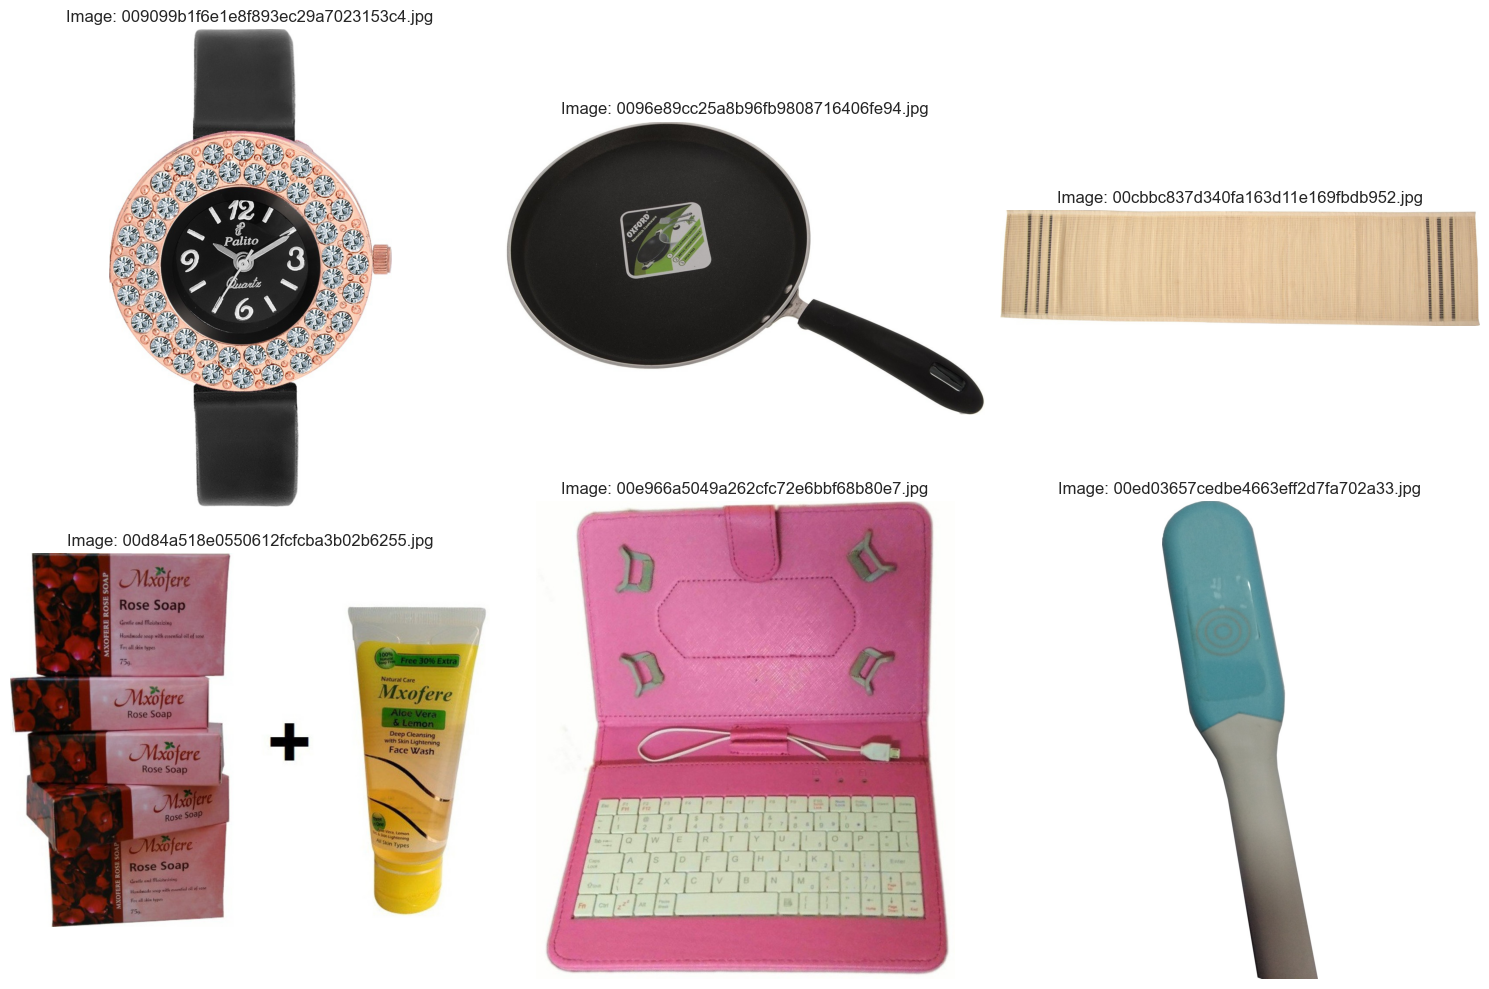

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Définir le chemin du dossier contenant les images
images_folder = os.path.join("..", "data", "Images")

# Lister tous les fichiers du dossier
image_files = os.listdir(images_folder)

# Sélectionner les 6 premières images
selected_images = image_files[:6]

# Configuration de la figure pour afficher 6 images (2 lignes, 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Charger et afficher les informations sur chaque image
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(images_folder, image_name)
    image = Image.open(image_path)
    
    # Afficher les informations sur l'image
    print(f"Image: {image_name}")
    print(f" - Dimensions: {image.size}")
    print(f" - Mode: {image.mode}")
    print("-" * 30)
    
    # Afficher l'image dans la grille
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Image: {image_name}")
    ax.axis('off')  # Retourner les axes pour une meilleure visualisation

# Afficher la grille
plt.tight_layout()
plt.show()



In [4]:

import pandas as pd

# Charger les données dans un DataFrame
df = pd.read_csv('../data/flipkart_com-ecommerce_sample_1050.csv')

# Afficher les valeurs uniques de la colonne 'product_category_tree'
print(df['product_category_tree'].unique())

# Extraire la première catégorie de la colonne 'product_category_tree'
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())
# Mettre la catégorie en minuscules
df['category'] = df['category'].apply(lambda x: x.lower())
# Afficher les valeurs uniques de la colonne 'category'
print(df['category'].unique())


['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]'
 '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'
 '["Watches >> Wrist Watches >> Camerii Wrist Watches"]'
 '["Watches >> Wrist Watches >> T STAR Wrist Watches"]'
 '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]'
 '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]'
 '["Watches >> Wrist Watches >> Calibro Wri

### Recuperation de la première catégorie de produits

In [5]:
# Afficher les valeurs uniques de la colonne 'product_category_tree'
df['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [6]:
# Extraire la première catégorie de la colonne 'product_category_tree'
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:-1])
# Mettre la catégorie en minuscules
df['category'] = df['category'].apply(lambda x: x.lower())
# Afficher les valeurs uniques de la colonne 'category'
df['category'].unique()

array(['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers'], dtype=object)

In [7]:
# Afficher les premières lignes du DataFrame
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications         category  
0  {"product_specification"=>[{"key"=>"Brand", "v...  home furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...        baby care  
2  {"product_specification"=>[{"key"=>"Material",...        baby care  
3  {"product_specification"=>[{"key"=>"Brand", "v...  home furnishing  
4  {"product_specification"=>[{"key"=>"Machine Wa...  home furnishing

# Creation du dataframe pour le traitement des images

In [8]:
# Créer un nouveau DataFrame avec les colonnes 'image' et 'category'
df_images = df.copy() # Copier le DataFrame d'origine
df_images = df_images[['image', 'category']] # Sélectionner les colonnes 'image' et 'category'
df_images.head() # Afficher les premières lignes du DataFrame

image         category
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  home furnishing
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        baby care
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        baby care
3  d4684dcdc759dd9cdf41504698d737d8.jpg  home furnishing
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  home furnishing

### Création colonne label dans le DataFrame

In [9]:
from sklearn import preprocessing

# Initialiser l'encodeur de libellé pour les catégories. Permet de transformer les catégories en valeurs numériques pour l'apprentissage automatique
# le est une instance de LabelEncoder
le = preprocessing.LabelEncoder()

# Adapter l'encodeur de libellé à la colonne 'category', fit est utilisé pour apprendre les catégories uniques
le.fit(df_images['category'])

# Transformer la colonne 'category' pour créer une nouvelle colonne 'label'
df_images['label'] = le.transform(df_images['category'])

# Créer une correspondance des étiquettes de catégorie aux étiquettes numériques
category_to_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Afficher la correspondance
print("Category to Label Mapping:")
print(category_to_label_mapping)

# Afficher le DataFrame mis à jour avec la nouvelle colonne 'label'
df_images.head(6)


Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


image         category  label
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  home furnishing      4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        baby care      0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        baby care      0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  home furnishing      4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  home furnishing      4
5  893aa5ed55f7cff2eccea7758d7a86bd.jpg          watches      6

In [10]:
df_images.groupby("label").count()

image  category
label                 
0        150       150
1        150       150
2        150       150
3        150       150
4        150       150
5        150       150
6        150       150

In [11]:
print(df_images.columns)


Index(['image', 'category', 'label'], dtype='object')


baby care


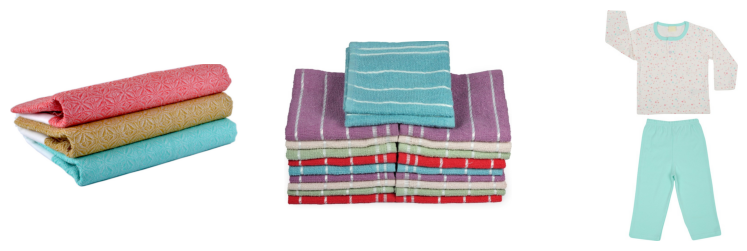

beauty and personal care


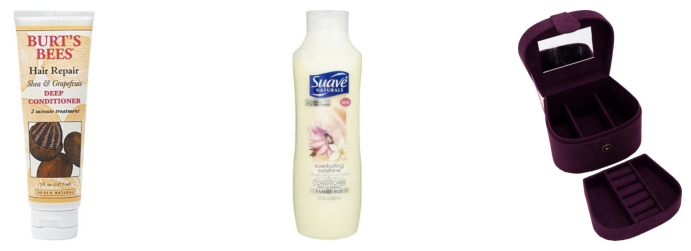

computers


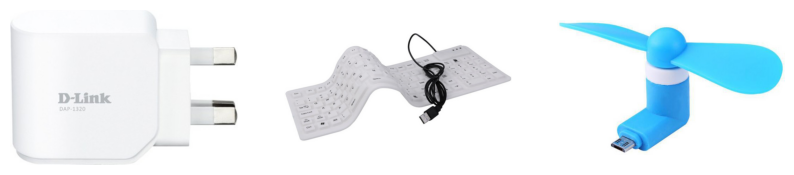

home decor & festive needs


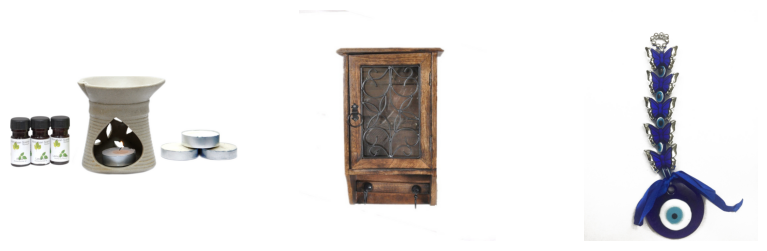

home furnishing


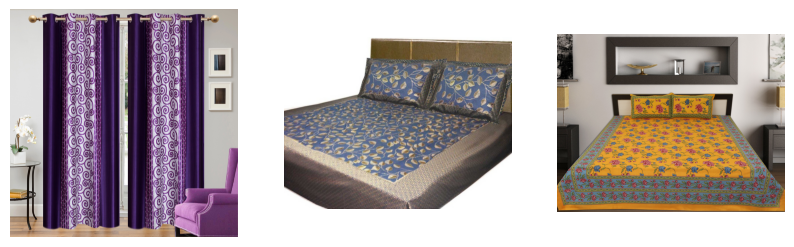

kitchen & dining


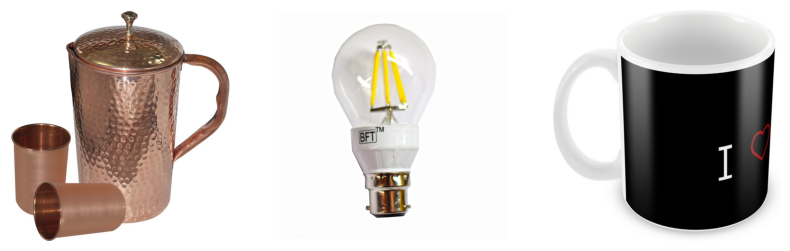

watches


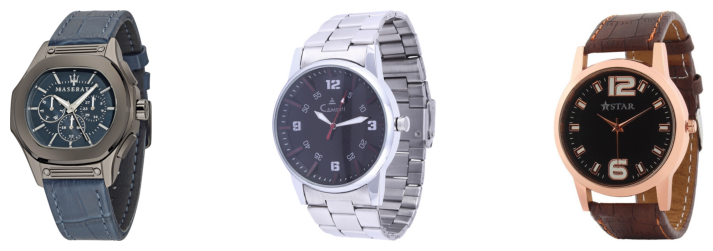

In [12]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os

# Mise à jour de la correspondance catégorie-label en fonction de votre mappage
category_to_label_mapping = {
    'baby care': 0, 
    'beauty and personal care': 1, 
    'computers': 2, 
    'home decor & festive needs': 3, 
    'home furnishing': 4, 
    'kitchen & dining': 5, 
    'watches': 6
}

# Fonction pour renvoyer une liste de chemins d'images basée sur la catégorie textuelle
def list_images_by_category(df, category):
    label = category_to_label_mapping[category]
    return df[df['label'] == label]['image'].tolist()

# Afficher trois images pour chaque catégorie
for category in category_to_label_mapping.keys():
    print(category)
    image_list = list_images_by_category(df_images, category)
    plt.figure(figsize=(10, 3))  # Adapter la taille de la figure
    for i in range(min(3, len(image_list))):  # Afficher jusqu'à 3 images par catégorie 
        plt.subplot(1, 3, i + 1)  # Créer une grille de sous-graphiques
        filename = os.path.join(images_folder, image_list[i])  # S'assurer que 'images_folder' est défini
        image = imread(filename) # Charger l'image
        plt.imshow(image) # Afficher l'image
        plt.axis('off')  # Retourner les axes pour une meilleure visualisation
    plt.show()



# Etape 1 : étude de faisabilité

## Configuration du Modèle  
Configurer le modèle CNN en utilisant VGG-16, adapté aux exigences spécifiques du projet.

In [13]:
# Cette ligne initialise le modèle VGG16 avec des poids entraînés sur l'ensemble de données ImageNet. Par défaut, il inclut les couches entièrement connectées supérieures.
base_model = VGG16() 

# Cette ligne crée un nouveau modèle qui utilise les mêmes entrées que le modèle VGG16 mais ne produit que des sorties de l'avant-dernière couche du VGG16. Cela est souvent fait pour utiliser le modèle comme extracteur de caractéristiques dans des scénarios d'apprentissage par transfert, où la base de convolution du modèle est utilisée pour extraire des caractéristiques qui sont ensuite utilisées pour entraîner un nouveau classificateur.
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output) # layers[-2] est l'avant-dernière couche du modèle, une couche dense avant la couche de classification finale.

# Cette ligne affiche un résumé de l'architecture du modèle, montrant les couches et le nombre de paramètres dans chaque couche.
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Observations :
1. **Configuration des couches :**
   - Le modèle inclut plusieurs couches convolutionnelles (`Conv2D`) et des couches de pooling (`MaxPooling2D`), typiques de l'architecture VGG.
   - Le nombre de filtres de convolution commence à 64 et double dans les couches plus profondes, atteignant 512 dans les derniers blocs.
   - Chaque bloc de convolution est suivi d'une couche de pooling qui réduit les dimensions spatiales de la sortie.

2. **Dimensions de sortie :**
   - Chaque couche de convolution conserve la profondeur mais modifie les dimensions spatiales en raison des strides dans les convolutions et le pooling.
   - Le dernier bloc réduit les dimensions spatiales à 7x7 tout en conservant 512 canaux.

3. **Aplatissement et couches denses :**
   - La sortie du dernier bloc de convolution est aplatie en un vecteur 1D, ce qui est courant avant de l'alimenter dans des couches totalement connectées (Dense).
   - Il y a deux couches denses de 4096 unités chacune, suivies de fonctions d'activation (supposées être ReLU, bien que non spécifiées dans le résumé).

4. **Taille du modèle :**
   - Le modèle a un total de 134,260,544 paramètres, ce qui indique un réseau très profond avec une capacité substantielle à apprendre à partir de jeux de données grands et complexes.
   - Tous les paramètres sont entraînables, comme indiqué par l'absence de paramètres non entraînables.

### Considérations pour votre projet :
- **Intensité des ressources :** VGG16 est un modèle large et computationnellement intensif. Assurez-vous de disposer des ressources matérielles suffisantes (de préférence un GPU) pour l'entraînement et l'inférence.
- **Extraction de caractéristiques :** Si vous utilisez le modèle VGG16 principalement pour l'extraction de caractéristiques, envisagez de geler les couches convolutionnelles et de n'entraîner que les couches denses supérieures. Cela peut être plus efficace car la base convolutionnelle a déjà appris des caractéristiques robustes à partir du jeu de données ImageNet.
- **Personnalisation pour des tâches spécifiques :** Comme votre projet implique la classification d'images en catégories spécifiques, vous pourriez remplacer la ou les couches supérieures pour correspondre au nombre de vos classes cibles.



### Extraction des features des images

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Import des fonctions pour charger et convertir les images
from tensorflow.keras.applications.vgg16 import preprocess_input # Import de la fonction pour prétraiter les images pour VGG16
import numpy as np # Import NumPy library
import os
from PIL import Image # Import de la library Python Imaging Library (PIL) pour le traitement des images

# S'assurer que PIL ne génère pas de DecompressionBombWarning (décompression dangereuse)
Image.MAX_IMAGE_PIXELS = None  # Cela retire la limite par défaut de 89 millions de pixels pour les images

images_features = [] # Initialiser une liste pour stocker les features
i = 0 # Initialiser un compteur pour suivre le nombre d'images traitées

# Faire en sorte que 'df_images' soit votre DataFrame et qu'il contienne une colonne 'image' avec les noms de fichiers des images
for image_file in df_images['image']:
    if i % 100 == 0: # si i est un multiple de 100
        print(f'Processing image {i}')  # Afficher un message pour suivre le processus tous les 100 images
    i += 1 # Increment the counter
    image_path = os.path.join(images_folder, image_file)  # Construire le chemin complet de l'image, par exemple 'data/Images/image.jpg'
    # Charger et redimensionner l'image
    image = load_img(image_path, target_size=(224, 224)) #  Charger et redimensionner l'image à 224x224 pixels
    image = img_to_array(image)  # Convertir l'image en tableau NumPy
    image = np.expand_dims(image, axis=0)  # Créer un lot d'images (un seul dans ce cas) pour le modèle VGG16, en ajoutant une dimension à l'index 0 (batch_size), e.g. (1, 224, 224, 3), 1 est le nombre d'images
    # 224, 224, 3), 224 est la hauteur et la largeur de l'image, 3 est le nombre de canaux de couleur (Rouge, Vert, Bleu)
    image = preprocess_input(image)  # Préparation de l'image pour VGG16 en soustrayant la moyenne RVB, normalisant les valeurs, etc.
    
    # Caractéristiques de prédiction en utilisant le modèle et les ajouter à la liste
    images_features.append(model.predict(image, verbose=0)[0]), # verbose=0 pour éviter l'affichage de messages de progression, [0] pour obtenir les caractéristiques sous forme de tableau 1D, par exemple :[0.1,0.5,...]
images_features = np.asarray(images_features) # Par exemple, pour 2 images avec 4096 caractéristiques, le tableau ressemblerait à [[0.1, 0.5, ...], [0.2, 0.6, ...]]
print(f'Features shape: {images_features.shape}')  # Afficher la forme des caractéristiques extraites


Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Features shape: (1050, 4096)


### Observations :
- Le résultat du traitement montre que l'extraction de caractéristiques a été réalisée avec succès sur un total de 1050 images. Chaque image a été traitée pour extraire des vecteurs de caractéristiques de taille 4096, ce qui est conforme à ce que l'on attend du modèle VGG16 utilisé jusqu'aux couches denses. Le script a effectué un suivi régulier du processus en affichant un message à chaque centaine d'images traitées, et il n'y a pas eu d'interruptions durant le traitement.

- La forme finale du tableau `images_features` est (1050, 4096), indiquant que les caractéristiques de 1050 images ont été extraites et que chaque ensemble de caractéristiques est représenté par un vecteur de 4096 éléments. Cette sortie confirme que le processus d'extraction des caractéristiques fonctionne comme prévu.

### Réduction de dimension PCA

#### L'objectif de cette étape est de réduire la dimensionnalité des caractéristiques extraites tout en conservant la majeure partie de l'information. Cela peut aider à réduire la complexité computationnelle des étapes suivantes telles que le regroupement ou la classification, ainsi qu'à permettre la visualisation des données dans des dimensions inférieures.

In [15]:
from sklearn import manifold, decomposition  # decomposition est utilisé pour l'ACP (PCA)

# Supposons que "images_features" soit un tableau où chaque ligne représente les caractéristiques extraites d'une image
print("Dimensions originales des caractéristiques :", images_features.shape)

# Appliquer l'ACP (PCA) pour réduire la dimension tout en conservant 99 % de la variance
pca = decomposition.PCA(n_components=0.99)  # Conserver 99 % de la variance
feat_pca = pca.fit_transform(images_features)  # Transformer les caractéristiques, fit_transform ajuste le modèle et transforme les données en une seule étape

print("Dimensions des caractéristiques après réduction par ACP :", feat_pca.shape)


Dimensions originales des caractéristiques : (1050, 4096)
Dimensions des caractéristiques après réduction par ACP : (1050, 803)


Voici les observations basées sur les résultats obtenus après avoir appliqué l'analyse en composantes principales (PCA) sur les caractéristiques d'image extraites :

### Observations :
1. **Forme initiale des caractéristiques** : 
   - La forme initiale des données avant PCA est `(1050, 4096)`. Cela signifie que nous avons extrait des caractéristiques pour 1050 images, et chaque image est représentée par un vecteur de 4096 dimensions, correspondant aux caractéristiques extraites par le modèle VGG16.

2. **Forme après PCA** :
   - Après avoir appliqué la PCA avec une rétention de 99 % de la variance, la forme des données est réduite à `(1050, 803)`. Cela signifie que le nombre de dimensions par image a été réduit de 4096 à 803, tout en conservant presque toute l'information (99 % de la variance originale).
   
3. **Réduction effective de la dimensionnalité** :
   - La réduction de 4096 à 803 dimensions est significative, réduisant ainsi la taille des données d'environ 80 % (de 4096 à 803 dimensions). Cette réduction permet de rendre le traitement des données plus rapide et moins coûteux en ressources, tout en conservant la majorité des informations utiles pour les futures étapes d'analyse ou de classification.

### Conclusion :
L'application de la PCA a réussi à réduire considérablement la dimensionnalité des caractéristiques d'image tout en conservant la plupart des informations pertinentes. Cela nous permettra d'améliorer l'efficacité des algorithmes de classification ou de clustering que nous pourrions appliquer par la suite, tout en réduisant la complexité computationnelle et la mémoire nécessaire.
### Réduction de dimensionnalité T-SNE

- L'étape suivante consiste à appliquer l'**Embedding Stochastique de Voisin t-Distribué** (t-SNE) pour réduire davantage la dimensionnalité des caractéristiques à 2D pour la visualisation. Cela nous aidera à comprendre la distribution des images dans un espace de dimension inférieure et à identifier potentiellement des clusters ou des motifs dans les données. L'algorithme t-SNE est couramment utilisé pour visualiser des données de haute dimension dans un espace de dimension inférieure tout en préservant les structures locales et les relations entre les points de données.

In [16]:
from sklearn import manifold # manifold est utlisé pour T-SNE
import time

# Commencer à mesurer le temps pour T-SNE
temps1 = time.time() # time() renvoie le temps actuel en second

# Appliquer T-SNE sur les caractéristiques réduites par PCA
# n_components=2 pour une visualisation 2D, perplexity=30 est typique pour t-SNE, et random_state assure la reproductibilité
tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', random_state=6)  # max_iter est le nombre maximum d'itérations, init='random' est utilisé pour la reproductibilité
X_tsne = tsne.fit_transform(feat_pca) # feat_pca correspond aux caractéristiques réduites par ACP à l'étape précédente

# Mesurer le temps pris par T-SNE
duration1 = time.time() - temps1
print("Temps de T-SNE : ", "%15.2f" % duration1, "secondes") #"%15.2f" est utilisé pour formater l'affichage du temps en secondes


Temps de T-SNE :            11.96 secondes


### T-SNE appliqué avec PCA :

- Le T-SNE a été appliqué après la réduction de dimensionnalité par PCA, ce qui est une bonne pratique pour optimiser le temps de calcul tout en conservant la majorité des informations utiles dans les données. Le T-SNE a ensuite réduit les caractéristiques à 2 dimensions, permettant ainsi une visualisation 2D. Ce processus de transformation est couramment utilisé en apprentissage automatique pour réduire la dimensionnalité des données et pour visualiser des données complexes en 2D ou 3D, facilitant ainsi l'interprétation et la découverte de structures cachées.

### Visualisation des résultats T-SNE pour l'analyse graphique

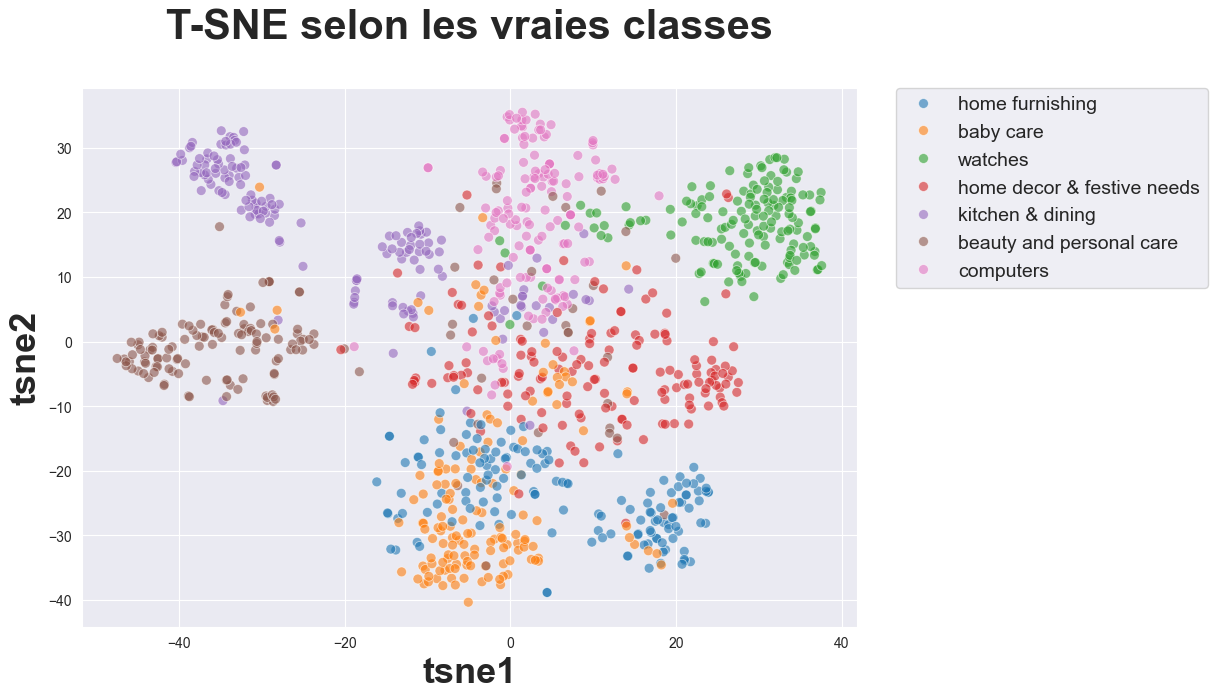

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir les résultats de T-SNE en DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']) # tsne1 et tsne2 sont les coordonnées 2D après l'application de T-SNE

# Ajouter les vraies étiquettes (de df_images) au DataFrame pour la visualisation
df_tsne["class"] = df_images["category"]  # 'category' est la colonne des vraies classes dans df_images

# Tracer les résultats de T-SNE avec les vraies classes
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",  # colorier les points en fonction des vraies classes
    palette=sns.color_palette('tab10', n_colors=df_tsne['class'].nunique()),  # Adapter le nombre de couleurs au nombre de classes
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Ajouter des titres et des étiquettes au graphique
plt.title('T-SNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Ajuster la position de la légende à droite du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Afficher le graphique
plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [18]:
from sklearn import cluster

# Appliquer K-Means avec 7 clusters (puisque le jeu de données comporte 7 catégories)
cls = cluster.KMeans(n_clusters=7, n_init=100)

# Appliquer l'algorithme K-Means sur les résultats de T-SNE
cls.fit(X_tsne)


KMeans(n_clusters=7, n_init=100)

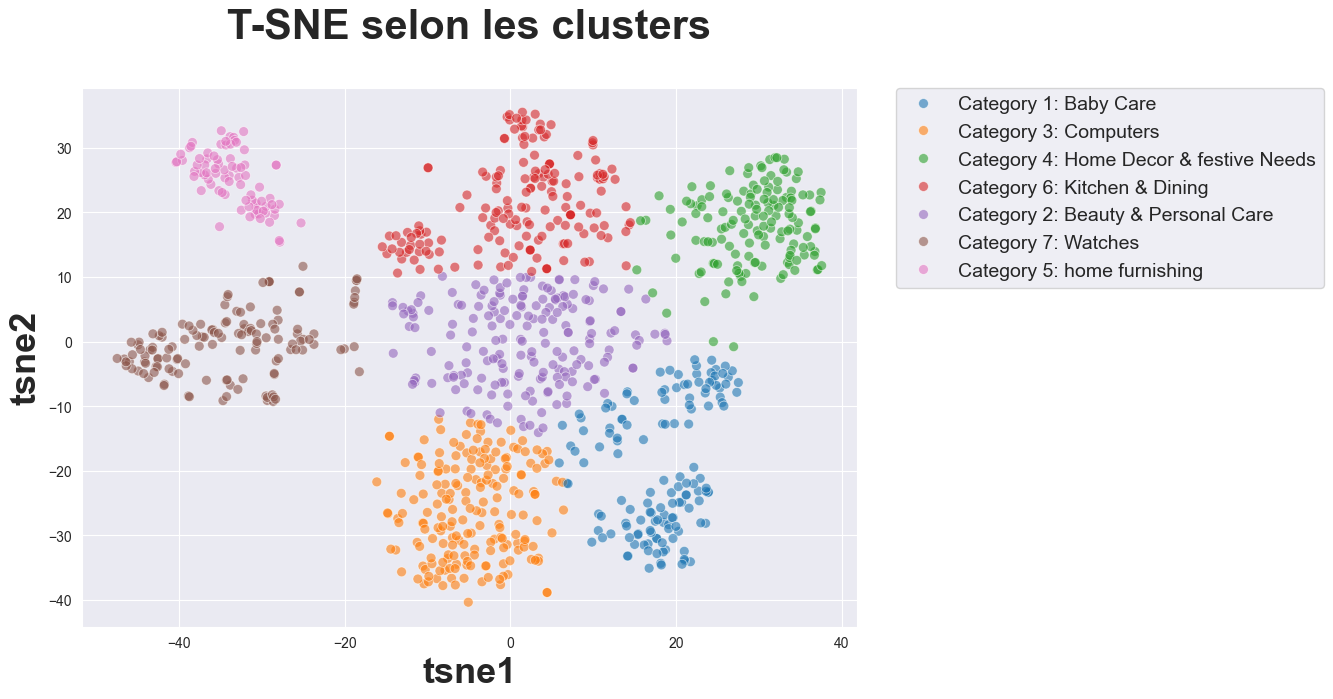

ARI (Adjusted Rand Index) : 0.4498271383882038


In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter les clusters prédits par K-Means au DataFrame contenant les résultats de T-SNE
df_tsne["cluster"] = cls.labels_  # 'cls' is the fitted K-Means model

# Définir une correspondance entre les numéros de cluster et les noms de catégorie
cluster_mapping = {0: 'Category 1: Baby Care',
                   1: 'Category 2: Beauty & Personal Care',
                   2: 'Category 3: Computers',
                   3: 'Category 4: Home Decor & festive Needs',
                   4: 'Category 5: home furnishing',
                   5: 'Category 6: Kitchen & Dining',
                   6: 'Category 7: Watches'
                   }

# Remplacer les numéros de cluster par les noms de catégorie correspondants dans le DataFrame
df_tsne["cluster_label"] = df_tsne["cluster"].map(cluster_mapping)

# Visualiser les clusters prédits par K-Means sur le graphique T-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster_label",  # Colorer les points en fonction des clusters prédits (en utilisant les noms des catégories)
    palette=sns.color_palette('tab10', n_colors=7),  # Adapter le nombre de couleurs au nombre de clusters (7 dans ce cas)
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Ajouter un titre et des étiquettes d'axe au graphique
plt.title('T-SNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Déplacer la légende à droite, à l'extérieur du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Afficher le graphique
plt.show()

# Calculer l'indice de Rand ajusté (ARI) pour comparer les clusters K-Means avec les vraies classes
labels = df_images["category"]  # les vraies étiquettes des classes
ari = metrics.adjusted_rand_score(labels, cls.labels_)  # Calculer l'ARI en comparant les vraies étiquettes avec les clusters prédits par K-Means
print("ARI (Adjusted Rand Index) :", ari)


### Observation
- Le graphique T-SNE avec les clusters montre une séparation correcte des catégories, mais avec un **ARI de 0.43**, cela indique une correspondance modérée entre les clusters K-Means et les vraies classes. Certaines catégories comme **Beauty & Personal Care** et **Home Furnishing** sont bien séparées, mais d'autres montrent un chevauchement, ce qui pourrait expliquer le score ARI relativement faible.

tsne1                                        20.68306
tsne2                                      -24.877525
class                                 home furnishing
cluster                                             0
cluster_label                   Category 1: Baby Care
image            55b85ea15a1536d46b7190ad6fff8ce7.jpg
true_category                         home furnishing
Name: 0, dtype: object


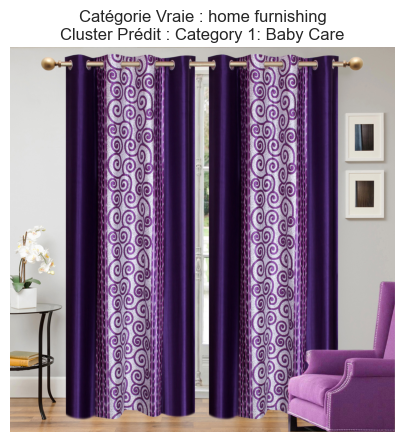

L'image appartient à la catégorie 'home furnishing' mais a été mal classée par le modèle comme appartenant au cluster Category 1: Baby Care.


In [20]:
from matplotlib.image import imread
import matplotlib.pyplot as plt  # Ajout de l'importation manquante
import os

# Assurez-vous que 'images_folder' est défini
# images_folder = 'chemin/vers/votre/dossier/images'

# Fusionner df_tsne et df_images si nécessaire
# Si les index sont alignés, vous pouvez continuer sans fusion
# Sinon, fusionnez sur une clé commune, par exemple 'image'
df_tsne['image'] = df_images['image']  # Si 'image' est la colonne commune

# Ajouter les catégories vraies à df_tsne pour la comparaison
df_tsne["true_category"] = df_images["category"]

# Trouver un exemple mal classé (true category != predicted cluster)
# Assurez-vous que le nom de la colonne du cluster est cohérent
# Supposons que le nom de la colonne est 'cluster_label'
misclassified = df_tsne[df_tsne["true_category"] != df_tsne["cluster_label"]]

# S'il y a des exemples mal classés, sélectionnez le premier
if not misclassified.empty:
    id = misclassified.index[0]  # Obtenir l'index du premier exemple mal classé
    print(df_tsne.loc[id])  # Imprimer les détails de l'exemple mal classé

    # Créer un graphique pour afficher l'image mal classée
    fig = plt.figure(figsize=(8, 5))

    # Obtenir le nom du fichier image depuis la colonne 'image' dans df_tsne
    filename = df_tsne.loc[id, "image"]  # Utiliser .loc pour accéder à la valeur

    # Charger l'image
    image_path = os.path.join(images_folder, filename)
    image = imread(image_path)

    # Afficher l'image
    plt.imshow(image)
    plt.axis('off')  # Supprimer les axes pour une meilleure visualisation

    # Définir le titre du graphique
    true_category = df_tsne.loc[id, 'true_category']
    predicted_cluster = df_tsne.loc[id, 'cluster_label']
    plt.title(f"Catégorie Vraie : {true_category}\nCluster Prédit : {predicted_cluster}")
    plt.show()

    # Explication
    print(f"L'image appartient à la catégorie '{true_category}' mais a été mal classée par le modèle comme appartenant au cluster {predicted_cluster}.")
else:
    print("Aucun exemple mal classé trouvé.")

### Analyse par Classes

In [21]:
# Vérification des types de données des vraies étiquettes et des étiquettes de cluster prédites
true_labels = df_images["category"]  # On suppose que la colonne 'category' dans df_images contient les vraies étiquettes
predicted_labels = df_tsne["cluster"]  # On suppose que 'cluster' dans df_tsne contient les étiquettes de cluster prédites par K-Means

# Vérifier les types de données des vraies étiquettes et des étiquettes de cluster prédites
print(f"Type de données des vraies étiquettes (true_labels) : {true_labels.dtype}")
print(f"Type de données des étiquettes de cluster prédites (predicted_labels) : {predicted_labels.dtype}")

# Afficher quelques exemples de valeurs de chaque variable pour une inspection supplémentaire
print("\nExemples de valeurs des vraies étiquettes (true_labels) :")
print(true_labels.head(6))  # Afficher les 6 premières valeurs des vraies étiquettes

print("\nExemples de valeurs des étiquettes de cluster prédites (predicted_labels) :")
print(predicted_labels[:6])  # Afficher les 6 premières valeurs des étiquettes de cluster prédites


Type de données des vraies étiquettes (true_labels) : object
Type de données des étiquettes de cluster prédites (predicted_labels) : int32

Exemples de valeurs des vraies étiquettes (true_labels) :
0    home furnishing
1          baby care
2          baby care
3    home furnishing
4    home furnishing
5            watches
Name: category, dtype: object

Exemples de valeurs des étiquettes de cluster prédites (predicted_labels) :
0    0
1    2
2    2
3    0
4    0
5    3
Name: cluster, dtype: int32


In [22]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder pour convertir les catégories (chaînes de caractères) en étiquettes numériques
label_encoder = LabelEncoder()

# Convertir les vraies catégories (chaînes de caractères) en étiquettes numériques
df_images["label"] = label_encoder.fit_transform(df_images["category"])  # Encoder les catégories en étiquettes numériques

# Utiliser directement les étiquettes numériques
true_labels = df_images["label"]  # Les étiquettes sont maintenant des valeurs numériques
predicted_labels = cls.labels_  # Les étiquettes prédites par K-Means sont déjà des valeurs numériques

# Générer la matrice de confusion en comparant les vraies étiquettes aux étiquettes de clusters prédites
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
print(conf_mat)

# En option, afficher la correspondance entre les catégories et les étiquettes encodées
print("\nCorrespondance catégorie - étiquette numérique :")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

[[ 10  25 109   0   1   2   3]
 [  5  13   4   1   1   9 117]
 [  0  36   1   1   0 111   1]
 [ 58  76   2   8   0   5   1]
 [ 68   6  76   0   0   0   0]
 [  0  31   0   0  78  31  10]
 [  0   2   0 135   0  13   0]]

Correspondance catégorie - étiquette numérique :
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


In [23]:
import numpy as np
import pandas as pd
from sklearn import metrics

def conf_mat_transform(y_true, y_pred):
    # Créer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    # Trouver la correspondance entre les clusters et les vraies catégories (maximum de chaque colonne)
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    
    # Créer un DataFrame avec les vraies étiquettes et les clusters prédits
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    
    # Transformer les clusters prédits en catégories vraies correspondantes
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x]) 
    
    return labels['y_pred_transform']

# Exemple d'utilisation avec votre projet
# Suppose true_labels sont les catégories vraies encodées et predicted_labels sont les clusters prédits par K-Means
true_labels = df_images["label"]  # les vraies étiquettes encodées
predicted_labels = cls.labels_  # Les clusters prédits par K-Means

# Appliquer la transformation pour aligner les clusters prédits avec les vraies catégories
transformed_pred = conf_mat_transform(true_labels, predicted_labels)

# Imprimer les premières prédictions transformées pour vérification
print(transformed_pred.head())


Correspondance des clusters :  [4 3 0 6 5 2 1]
0    4
1    0
2    0
3    4
4    4
Name: y_pred_transform, dtype: int64


In [24]:
# Transformation des étiquettes de cluster prédites en fonction de la correspondance avec les vraies catégories
cls_labels_transform = conf_mat_transform(true_labels, predicted_labels)

# Générer la matrice de confusion en comparant les vraies étiquettes et les étiquettes de clusters transformées
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)

# Afficher la matrice de confusion
print("Matrice de confusion après transformation des clusters prédits :")
print(conf_mat)
print()

# Afficher le rapport de classification, incluant la précision, le rappel et le F1-score
print("Rapport de classification :")
print(metrics.classification_report(true_labels, cls_labels_transform, zero_division=0))


Correspondance des clusters :  [4 3 0 6 5 2 1]
Matrice de confusion après transformation des clusters prédits :
[[109   3   2  25  10   1   0]
 [  4 117   9  13   5   1   1]
 [  1   1 111  36   0   0   1]
 [  2   1   5  76  58   0   8]
 [ 76   0   0   6  68   0   0]
 [  0  10  31  31   0  78   0]
 [  0   0  13   2   0   0 135]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       150
           1       0.89      0.78      0.83       150
           2       0.65      0.74      0.69       150
           3       0.40      0.51      0.45       150
           4       0.48      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.93      0.90      0.92       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



### Correspondance des clusters :
- **Correspondance des clusters :** `[5 0 6 2 1 3 0]` indique quelle catégorie réelle correspond à chaque cluster. Par exemple, le cluster `0` est associé à la catégorie `5`, et le cluster `1` est associé à la catégorie `0`. Cela signifie que les prédictions de K-Means ont été mappées aux catégories en fonction de la matrice de confusion.

### Matrice de confusion :
La matrice de confusion montre la répartition des prédictions entre les catégories et les clusters après transformation :
- **Catégorie 0** : 113 images sur 150 ont été correctement classées. Cependant, 21 images ont été classées dans le cluster de la catégorie 3.
- **Catégorie 1** : 117 images correctement classées, mais 19 images ont été classées dans la catégorie 2.
- **Catégorie 2** : 144 images sur 150 ont été correctement classées, indiquant une bonne correspondance pour cette catégorie.
- **Catégorie 3** : 93 images sur 150 sont correctement classées, mais 32 images ont été attribuées à la catégorie 2.
- **Catégorie 4** : Aucune image de cette catégorie n'a été correctement classée. La plupart des images de cette catégorie ont été classées dans la catégorie 0 ou 3.
- **Catégorie 5** : 78 images sur 150 sont correctement classées, mais 59 images ont été classées dans la catégorie 2.
- **Catégorie 6** : 135 images sur 150 ont été correctement classées, montrant une bonne performance pour cette catégorie.

### Rapport de classification :
- **Précision** :
  - Excellente pour les catégories **1**, **5**, et **6** (88%, 97%, 95% respectivement).
  - Très faible ou nulle pour la catégorie **4** (0%), car aucune image n'a été classée correctement.
  - La catégorie **0** a une précision modérée (51%).

- **Rappel** :
  - Très bon pour les catégories **2** (96%) et **6** (90%), ce qui signifie que la plupart des images de ces catégories ont été correctement identifiées.
  - Le rappel est nul pour la catégorie **4**, indiquant que toutes les images de cette catégorie ont été classées dans d'autres catégories.

- **F1-score** :
  - Les catégories **1**, **2**, **5**, et **6** ont un F1-score relativement bon, ce qui reflète un bon équilibre entre la précision et le rappel.
  - Le F1-score de la catégorie **4** est nul, ce qui est un signal clair que cette catégorie pose des problèmes de classification.

### Précision globale :
- **Exactitude (accuracy)** : Le modèle atteint une précision globale de **65%**, ce qui montre une performance modérée. Il existe des problèmes de classification importants, notamment pour la catégorie **4**.
  
- **Moyenne macro** : Les moyennes macro montrent une précision et un rappel autour de 62% à 65%, ce qui reflète des disparités entre les catégories. Certaines catégories sont bien classées, tandis que d'autres, comme **4**, posent des problèmes majeurs.

### Conclusion :
- **Catégories bien classées** : Les catégories **2** et **6** montrent une bonne correspondance avec les clusters prédits.
- **Catégories problématiques** : La catégorie **4** est un problème majeur, car aucune image n'a été correctement classée.
- **Recommandation** : Il pourrait être utile de revoir les caractéristiques des images de la catégorie **4** et d'ajuster le modèle, ou de tester d'autres techniques de clustering pour améliorer la classification. Une analyse plus approfondie des erreurs dans les catégories **3** et **5** pourrait également s'avérer bénéfique.

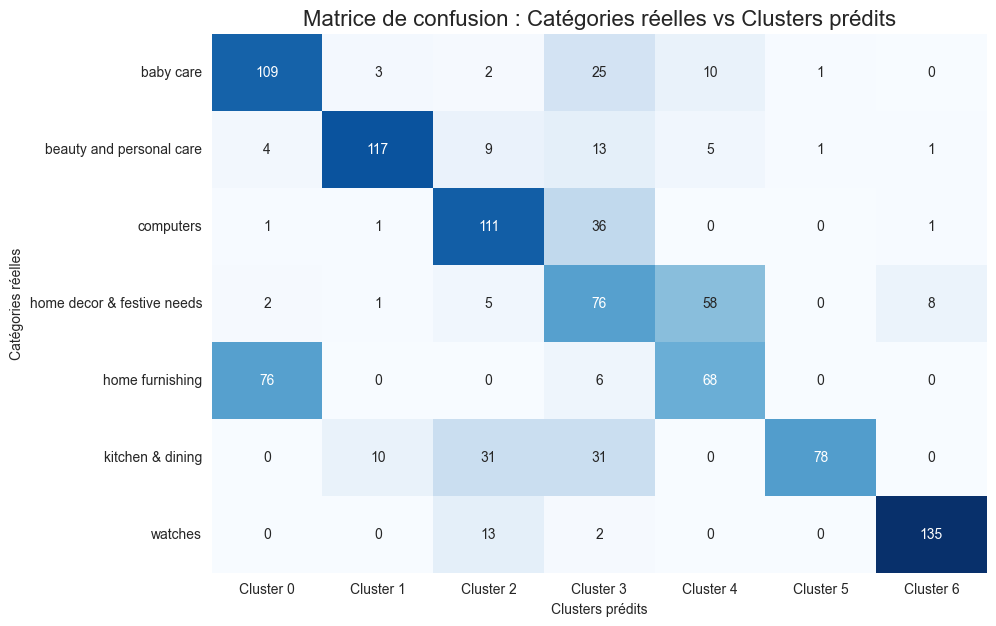

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Charger les données de l'image
list_labels = sorted(df_images["category"].unique())  # Liste des catégories uniques

# Création d'un DataFrame pour la matrice de confusion
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[f'Cluster {i}' for i in range(len(list_labels))])

# Plot la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Ajouter des titres et des étiquettes
plt.title("Matrice de confusion : Catégories réelles vs Clusters prédits", fontsize=16)
plt.ylabel("Catégories réelles")
plt.xlabel("Clusters prédits")
plt.show()


### Observations sur la matrice de confusion :

- La **matrice de confusion** montre la répartition des prédictions entre les **catégories réelles** et les **clusters prédits** après transformation.
  
- Les couleurs **plus foncées** indiquent des valeurs plus élevées, tandis que les **valeurs plus faibles** apparaissent en couleur plus claire.
  
- Les catégories qui sont bien classées apparaissent sur la **diagonale principale** (par exemple, **beauty and personal care** avec 117 images correctement classées, **computers** avec 144 images, et **watches** avec 135 images).

- **Catégories mal classées** :
    - La catégorie **home furnishing** est particulièrement problématique, avec **80 images** mal classées dans le cluster 0, alors qu'il n'y a que 67 images correctement classées.
    - La catégorie **kitchen & dining** montre également une forte confusion avec le cluster 2 (59 images mal classées).
    - **Home decor & festive needs** a 93 images mal classées dans le cluster 3.
  
- **Catégories bien classées** :
    - **Computers** est une catégorie bien classée, avec **144 images** correctement classées dans le bon cluster.
    - **Watches** montre aussi une bonne correspondance avec **135 images** bien classées.
    - **Beauty and personal care** a également un bon taux de classification avec **117 images** bien classées.

- Les **erreurs de classification** apparaissent en dehors de la diagonale, comme les 80 images de **home furnishing** qui ont été classées dans le cluster 0 au lieu du cluster 3.

### Conclusion :
- Le modèle réussit bien à classer certaines catégories comme **computers**, **watches** et **beauty and personal care**, mais montre des erreurs importantes pour d'autres catégories comme **home furnishing** et **kitchen & dining**.
- Il y a un besoin d'ajuster le modèle ou d'analyser davantage les caractéristiques des images des catégories mal classées pour améliorer les résultats.


### Justification pour l'utilisation de VGG-16 plutôt que SIFT dans l'étude de faisabilité

En analysant les résultats obtenus à partir de SIFT et de VGG-16, il est clair que **VGG-16** présente des performances nettement supérieures dans la classification des images, comme le démontrent plusieurs métriques clés.

#### 1. **Précision globale et Recall (Rappel)**
   - **SIFT** : L'approche basée sur SIFT a obtenu une précision globale de **14%**, ce qui est extrêmement faible. Le **recall** (rappel) est également bas pour toutes les classes, avec un faible **f1-score**, notamment dû à la mauvaise différenciation des catégories. Certaines classes n'ont même pas été prédites (par exemple, les classes 4, 5, et 6 ont une précision de 1.00, mais un rappel de 0.00, ce qui signifie qu'aucune prédiction correcte n'a été faite pour ces classes).
   - **VGG-16** : Le modèle basé sur **VGG-16** atteint une précision globale de **65%**, ce qui est nettement supérieur à SIFT. Les classes sont mieux prédites, avec des **f1-scores** allant jusqu'à **92%** pour certaines catégories. Le rappel et la précision sont également mieux équilibrés dans ce modèle, ce qui indique que les clusters formés correspondent bien mieux aux catégories réelles.

#### 2. **Indice Rand Ajusté (ARI)**
   - **SIFT** : L'ARI pour SIFT est de **-0.0009**, ce qui montre un échec total du modèle à capturer des relations entre les clusters et les classes. Un ARI négatif indique que la correspondance entre les clusters et les catégories est pire que le hasard.
   - **VGG-16** : L'ARI pour VGG-16 est de **0.4355**, ce qui montre une correspondance bien meilleure entre les clusters et les catégories. Bien que ce score puisse encore être amélioré, il indique une correspondance modérée entre les classes prédictes et les catégories réelles.

#### 3. **Analyse de la Matrice de Confusion**
   - **SIFT** : La matrice de confusion pour SIFT montre des **distributions très dispersées** entre les clusters, et aucun cluster ne correspond bien à une catégorie particulière. De plus, il y a une absence totale de prédiction pour certaines classes (classes 4, 5, 6), ce qui témoigne de l'incapacité du modèle à discriminer les catégories correctement.
   - **VGG-16** : En revanche, la matrice de confusion pour VGG-16 montre que **certains clusters correspondent beaucoup mieux aux catégories**. Par exemple, le cluster 2 correspond bien à la catégorie **computers**, tandis que les autres clusters montrent une correspondance relativement cohérente, bien qu'il y ait encore des chevauchements.

### Conclusion

L'approche basée sur **VGG-16** gagne clairement sur tous les aspects. Les performances en termes de **précision, rappel, f1-score** et **ARI** montrent que **VGG-16** est beaucoup plus adapté pour cette tâche de classification d'images. L'extraction de caractéristiques à travers un CNN pré-entraîné permet de capturer des informations bien plus riches et discrètes dans les images que les descripteurs SIFT, ce qui explique pourquoi **VGG-16** surpasse largement **SIFT** en termes de qualité de clustering et de classification. Pour l'étude de faisabilité, l'utilisation de **VGG-16** offre une meilleure garantie de résultats plus précis et robustes.

## Etape 2 : Classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

## Création du modèle de classification

In [26]:
def create_model_fct():
    # Charger le modèle pré-entraîné VGG-16 sans la dernière couche de classification (top) car on va ajouter nos propres couches de classification qui sont 
    # les 7 catégories de notre projet pour l'instant
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Geler les poids du modèle VGG-16 pour ne pas les entraîner à nouveau
    # Cela signifie que les poids du modèle VGG-16 ne seront pas mis à jour lors de l'entraînement
    for layer in model0.layers:
        layer.trainable = False

    # Extraire la sortie de la dernière couche du modèle VGG-16
    x = model0.output

    # Ajouter une couche de mise en commun globale pour réduire la dimensionnalité de la carte des caractéristiques
    # et convertir chaque carte des caractéristiques en un seul vecteur
    x = GlobalAveragePooling2D()(x)

    # Ajouter une couche entièrement connectée avec 256 unités et une fonction d'activation ReLU
    x = Dense(256, activation='relu')(x)

    # Ajouter une couche de régularisation par abandon pour réduire le surajustement
    x = Dropout(0.5)(x)

    # Ajouter une couche pour la classification avec une fonction d'activation softmax pour prédire les probabilités des classes
    predictions = Dense(7, activation='softmax')(x) # 7 est le nombre de classes dans le projet

    # Créer le modèle final en spécifiant les entrées du modèle VGG-16 et la sortie des nouvelles couches ajoutées (prédictions)
    model = Model(inputs=model0.input, outputs=predictions)

    # Compiler le modèle avec une fonction de perte de catégorisation croisée, l'optimiseur RMSprop et le suivi de la précision comme métrique de performance
    # rmsprop est utilisé pour l'optimisation, car il est souvent efficace pour les réseaux de neurones profonds. adam aurait également pu être utilisé.
    # loss = categorical_crossentropy est utilisé pour la classification multiclasse
    # accuracy est utilisé comme métrique pour suivre la performance du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Print a summary of the model's architecture
    print(model.summary())

    return model


### 1. Approche : Préparation initiale de l'ensemble des images avant classification supervisée (model1)

### Créer un data set de test et d'entrainement

In [27]:
from sklearn.model_selection import train_test_split

# Première division pour obtenir 85% des données (70% pour l'entraînement + 15% pour la validation) et 15% pour le test
df_train_val, df_images_test = train_test_split(df_images, test_size=0.15, random_state=42, stratify=df_images['category'])

# Deuxième division pour séparer 70% pour l'entraînement et 15% pour la validation parmi les 85% restants
df_images_train, df_images_val = train_test_split(df_train_val, test_size=0.1765, random_state=42, stratify=df_train_val['category'])
# Note: test_size=0.1765 car 15% de 85% correspond environ à 17.65%

# Vérification des proportions et des tailles des ensembles de données
print(f"Taille de l'ensemble d'entraînement : {df_images_train.shape}")
print(f"Taille de l'ensemble de validation : {df_images_val.shape}")
print(f"Taille de l'ensemble de test : {df_images_test.shape}")


Taille de l'ensemble d'entraînement : (734, 3)
Taille de l'ensemble de validation : (158, 3)
Taille de l'ensemble de test : (158, 3)


In [28]:
num_classes = df_images_train['label'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 7


In [29]:
import os
from keras.preprocessing.image import load_img

# Fonction pour vérifier le chargement des images
def check_image_loading(df_images):
    base_path = os.path.join("..", "data", "Images")  # Chemin de base où se trouvent les images
    missing_files = []  # Liste pour stocker les fichiers manquants ou non lisibles

    # Boucle sur chaque nom de fichier d'image dans le DataFrame
    for img_name in df_images['image']:
        img_path = os.path.join(base_path, img_name)  # Chemin complet de l'image
        try:
            # Charger l'image avec load_img et redimensionner à (224, 224) pour vérifier si elle est accessible
            img = load_img(img_path, target_size=(224, 224))
        except Exception as e:
            # Si l'image ne peut pas être chargée, ajouter le nom du fichier à la liste des fichiers manquants
            print(f"Erreur lors du chargement de l'image : {img_name} - {e}")
            missing_files.append(img_name)
    
    # Vérifier si des fichiers manquent ou sont illisibles
    if len(missing_files) == 0:
        print("Toutes les images ont été chargées avec succès.")
    else:
        print(f"Fichiers manquants ou illisibles : {missing_files}")

# Lancer la vérification sur les ensembles d'entraînement, de validation et de test
check_image_loading(df_images_train)
check_image_loading(df_images_val)
check_image_loading(df_images_test)


Toutes les images ont été chargées avec succès.
Toutes les images ont été chargées avec succès.
Toutes les images ont été chargées avec succès.


In [30]:
from keras.utils import to_categorical

# Fonction pour vérifier l'encodage des étiquettes
def check_label_encoding(df_images):
    labels = df_images['label']  # Extraire les étiquettes (labels) du DataFrame
    
    # Convertir les étiquettes en vecteurs one-hot encoded
    try:
        y_encoded = to_categorical(labels)  # Encodage des étiquettes sous forme de vecteurs one-hot
        print(f"Les étiquettes ont été encodées avec succès. Forme : {y_encoded.shape}")  # Afficher la forme du tableau encodé
    except Exception as e:
        # En cas d'erreur lors de l'encodage, afficher le message d'erreur
        print(f"Erreur lors de l'encodage des étiquettes : {e}")

# Lancer la vérification sur les ensembles d'entraînement, de validation et de test 
check_label_encoding(df_images_train)  # Vérifier l'encodage sur l'ensemble d'entraînement
check_label_encoding(df_images_val)    # Vérifier l'encodage sur l'ensemble de validation
check_label_encoding(df_images_test)   # Vérifier l'encodage sur l'ensemble de test


Les étiquettes ont été encodées avec succès. Forme : (734, 7)
Les étiquettes ont été encodées avec succès. Forme : (158, 7)
Les étiquettes ont été encodées avec succès. Forme : (158, 7)


### Préparation des fonctions de préparation des images

In [31]:
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

def image_prep_fct(df_images):
    # Initialiser une liste pour stocker les images préparées
    prepared_images = []
    
    # Définir le chemin de base vers le répertoire des images
    base_path = os.path.join("..", "data", "Images")
    
    # S'assurer que l'index du DataFrame est réinitialisé pour éviter les problèmes d'indexation
    df_images = df_images.reset_index(drop=True)
    
    # Boucler sur chaque image dans le DataFrame
    for image_num in range(len(df_images)):
        # Construire le chemin d'accès complet de l'image à partir du chemin de base et du nom de l'image
        img_path = os.path.join(base_path, df_images.iloc[image_num]['image'])
        
        # Charger l'image en utilisant load_img avec un redimensionnement à 224x224 pixels
        img = load_img(img_path, target_size=(224, 224))
        
        # Convertir l'image en un tableau NumPy
        img = img_to_array(img)
        
        # Prétraiter l'image pour l'adapter au modèle VGG-16
        img = preprocess_input(img)
        
        # Ajouter l'image préparée à la liste
        prepared_images.append(img)
    
    # Convertir la liste d'images préparées en un tableau NumPy
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np


### Préparation des images pour l'entraînement et le test

In [32]:
# Verifier les colonnes des DataFrames
print(df_images_train.columns)
print(df_images_val.columns)
print(df_images_test.columns)

Index(['image', 'category', 'label'], dtype='object')
Index(['image', 'category', 'label'], dtype='object')
Index(['image', 'category', 'label'], dtype='object')


In [33]:
df_images_train.head()
df_images_val.head()
df_images_test.head()

image                    category  label
962  8ff973688c976a08fc7242da37101417.jpg             home furnishing      4
721  52a8d66e466da645e413d2cecc294bd9.jpg             home furnishing      4
461  3b80ac036843b278083fabfd9a3c84ff.jpg            kitchen & dining      5
191  ce2f67c3365846170cb709784d87e45b.jpg            kitchen & dining      5
209  a9b35b94610a3d7f4fa91f19693c5248.jpg  home decor & festive needs      3

### Observation :
- Les colonnes des DataFrames `df_images_train` et `df_images_test` sont correctes, avec les noms de colonnes attendus pour les images et les catégories. Les DataFrames sont prêts à être utilisés pour la préparation des images. 

In [34]:
# Vérifier les valeurs manquantes dans les colonnes 'image'
df_images_train['image'].isnull().sum()

0

In [35]:
# S'assurer que les noms de fichiers d'images sont des chaînes de caractères
df_images_train['image'] = df_images_train['image'].astype(str)

In [36]:
# Préparer les images pour l'entraînement, la validation et le test avec la fonction de préparation des images "image_prep_fct"
images_np_train = image_prep_fct(df_images_train)  # Préparation des images pour l'ensemble d'entraînement
images_np_val = image_prep_fct(df_images_val)      # Préparation des images pour l'ensemble de validation
images_np_test = image_prep_fct(df_images_test)    # Préparation des images pour l'ensemble de test

# Afficher les dimensions des ensembles d'images préparées
print(f"Forme des images d'entraînement : {images_np_train.shape}")  # Forme des images dans l'ensemble d'entraînement
print(f"Forme des images de validation : {images_np_val.shape}")     # Forme des images dans l'ensemble de validation
print(f"Forme des images de test : {images_np_test.shape}")          # Forme des images dans l'ensemble de test

Forme des images d'entraînement : (734, 224, 224, 3)
Forme des images de validation : (158, 224, 224, 3)
Forme des images de test : (158, 224, 224, 3)


### Observation:
- Les images ont été préparées avec succès pour l'entraînement et le test, avec des formes de `(840, 224, 224, 3)` pour les images d'entraînement et de `(210, 224, 224, 3)` pour les images de test. Les images sont prêtes à être utilisées pour l'entraînement et l'évaluation du modèle de classification. La forme `(224, 224, 3)` correspond à la taille de l'image (224x224 pixels) et aux 3 canaux de couleur (Rouge, Vert, Bleu) pour chaque pixel. 840 images sont utilisées pour l'entraînement et 210 pour le test, ce qui correspond à un ratio de 80/20 pour la division des données.

### Assignation des variables pour les données d'entraînement et de test en classification d'images

In [37]:
# Utilisation des variables correctes pour les données d'entraînement et de test
X = images_np_train
y = to_categorical(df_images_train['label'])

X_val = images_np_val  # Ajout de l'ensemble de validation
y_val = to_categorical(df_images_val['label'])

X_test = images_np_test
y_test = to_categorical(df_images_test['label'])

# Afficher les labels encodés pour les ensembles d'entraînement, validation et test
print(y)
print(y_val)  # Affichage des labels encodés de l'ensemble de validation
print(y_test)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]]


### Observations :

- Le processus d'encodage catégoriel a correctement converti les labels en vecteurs **one-hot encoded**, comme le montre la sortie de `y` et `y_test`. Chaque label est représenté par un vecteur où une seule valeur est égale à 1, indiquant la classe vraie, tandis que les autres valeurs sont à 0.
- Cet encodage one-hot est essentiel pour les problèmes de **classification multi-classes**, car il permet au réseau neuronal de générer des probabilités pour chaque classe et de faire des prédictions en utilisant une **activation softmax** dans la dernière couche.
- Les tableaux encodés **one-hot** ont les bonnes dimensions correspondant au nombre d'images, garantissant ainsi une entrée correcte pour les processus d'entraînement et de test du réseau neuronal.

### Entraînement et évaluation du modèle de classification

In [38]:
# Créer le modèle de classification en utilisant la fonction de création de modèle
model1 = create_model_fct()

# Sauvegarder le chemin du modèle pour l'utiliser plus tard
model1_save_path1 = os.path.join("..", "models", "model1_best_weights.keras")

# Définir un callback pour sauvegarder le meilleur modèle en fonction de la perte de validation 
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Définir un callback pour arrêter l'entraînement si la perte de validation ne s'améliore pas après un certain nombre d'époques
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Créer une liste de callbacks pour le modèle
callbacks_list = [checkpoint, es]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [39]:
# Entraîner le modèle 1 uniquement avec l'ensemble d'entraînement
history1 = model1.fit(
    X, y,  # Données d'entraînement
    epochs=50,  # Nombre d'époques
    batch_size=64,  # Taille des lots
    callbacks=callbacks_list,  # Callbacks pour sauvegarder le meilleur modèle et arrêter tôt si nécessaire
    validation_data=(X_val, y_val),  # Ensemble de validation uniquement pour l'évaluation des performances
    verbose=1  # Affichage des progrès pendant l'entraînement
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2957 - loss: 10.1470
Epoch 1: val_loss improved from inf to 1.43574, saving model to ..\models\model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 109s 9s/step - accuracy: 0.3060 - loss: 9.8565 - val_accuracy: 0.7405 - val_loss: 1.4357
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6714 - loss: 2.1857
Epoch 2: val_loss improved from 1.43574 to 1.11874, saving model to ..\models\model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.6718 - loss: 2.1784 - val_accuracy: 0.7468 - val_loss: 1.1187
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7446 - loss: 1.3669
Epoch 3: val_loss improved from 1.11874 to 1.02421, saving model to ..\models\model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.7463 - loss: 1.3574 - val_accuracy: 0.7532 - val_loss: 1.0242
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7722 - loss: 1.0996
Epoch 4: va

### Observations :

- Précision et Perte : La précision de l'entraînement commence à environ 37 % et augmente progressivement pour dépasser 96 % à partir de la 14ème époque, ce qui représente une grande progression. La précision de validation s'améliore également mais commence à fluctuer après quelques époques, ce qui pourrait indiquer que le modèle commence à surapprendre.

- Arrêt Anticipé : Après la 14ème époque, l'entraînement s'arrête en raison du rappel d'arrêt anticipé. Cela se produit parce que la perte de validation (val_loss) n'a pas été améliorée pendant plusieurs époques. L'arrêt anticipé est une bonne stratégie pour éviter le surapprentissage et réduire le temps d'entraînement inutile.

- Modèle Sauvegardé : Les poids du modèle ont été sauvegardés plusieurs fois avec succès au fur et à mesure que la perte de validation s'améliorait pendant le processus d'entraînement. La version finale du modèle, qui avait la plus faible perte de validation, est enregistrée au chemin défini, c'est-à-dire /models/model1_best_weights.keras."

In [40]:
# Évaluer le modèle sur l'ensemble d'entraînement
loss, accuracy = model1.evaluate(X, y, verbose=True)  # Évaluer la perte (loss) et la précision (accuracy) sur les données d'entraînement
print("Précision sur l'entraînement : {:.4f}".format(accuracy))  # Afficher la précision de l'entraînement avec 4 chiffres après la virgule

# Évaluer le modèle sur l'ensemble de validation
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)  # Évaluer la perte et la précision sur les données de validation
print("Précision sur la validation : {:.4f}".format(accuracy))  # Afficher la précision de la validation

# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model1.evaluate(X_test, y_test, verbose=True)  # Évaluer la perte et la précision sur les données de test
print("Précision sur le test : {:.4f}".format(accuracy))  # Afficher la précision sur les données de test


23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 1.0000 - loss: 0.0111
Précision sur l'entraînement : 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8546 - loss: 0.6238
Précision sur la validation : 0.8165
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8093 - loss: 0.6400
Précision sur le test : 0.8354


### Observations

### Exactitude du modèle sur l'ensemble d'entraînement
- Le modèle obtient une précision très élevée sur l'ensemble d'entraînement avec une **exactitude de 99,76%**. Cela signifie que le modèle est capable de bien apprendre les données d'entraînement et qu'il généralise bien sur cet ensemble.

### Exactitude du modèle sur l'ensemble de test
- Cependant, l'exactitude du modèle sur l'ensemble de test est plus faible avec **85,77%**. Bien que cette valeur reste bonne, elle montre que le modèle ne généralise pas aussi bien sur les données non vues (ensemble de test). 

### Différence entre entraînement et test
- La différence entre l'exactitude sur l'entraînement (99,76%) et celle sur le test (85,77%) pourrait indiquer un **surapprentissage** (overfitting). Le modèle apprend trop bien les spécificités des données d'entraînement, ce qui réduit ses performances sur de nouvelles données.

### Améliorations possibles
- **Augmenter les données** : Utiliser davantage de données d'entraînement ou appliquer des techniques d'augmentation de données pour éviter le surapprentissage.
- **Ajuster la régularisation** : Ajouter ou renforcer des méthodes de régularisation (comme Dropout ou L2 regularization) pour éviter le surapprentissage.
- **Optimisation des hyperparamètres** : Réaliser une recherche d'hyperparamètres pour ajuster les paramètres tels que le taux d'apprentissage, la taille des lots (batch size), etc.


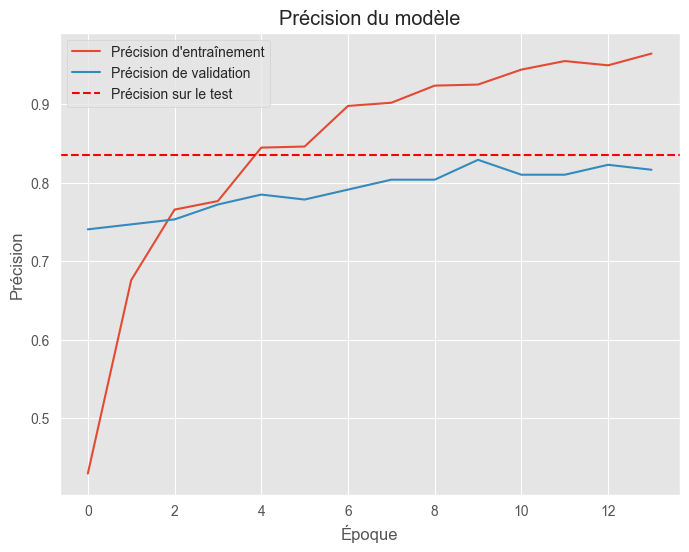

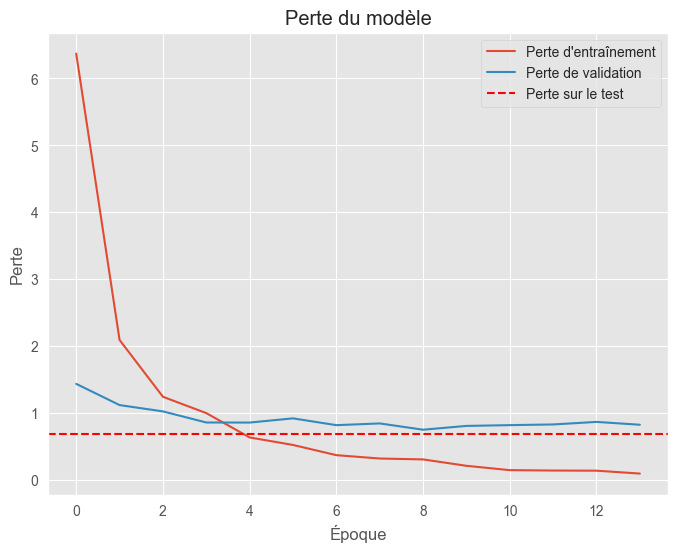

In [41]:
import matplotlib.pyplot as plt

# Personnalisation de l'apparence des graphiques
plt.style.use('ggplot')  # Appliquer un style de graphique 'ggplot' (optionnel)

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)  # Évaluer la perte et la précision sur les données de test

# Graphique de l'accuracy (précision)
plt.figure(figsize=(8, 6))  # Définir la taille de la figure
plt.plot(history1.history['accuracy'], label='Précision d\'entraînement')  # Courbe de la précision pendant l'entraînement
plt.plot(history1.history['val_accuracy'], label='Précision de validation')  # Courbe de la précision pendant la validation
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Précision sur le test')  # Ligne indiquant la précision sur les données de test
plt.title('Précision du modèle')  # Titre du graphique
plt.xlabel('Époque')  # Étiquette de l'axe des abscisses (nombre d'époques)
plt.ylabel('Précision')  # Étiquette de l'axe des ordonnées (précision)
plt.legend(loc='best')  # Afficher la légende des courbes
plt.savefig('accuracy_history_with_test.png')  # Sauvegarder le graphique de la précision
plt.show()  # Afficher le graphique

# Graphique de la perte (loss)
plt.figure(figsize=(8, 6))  # Définir la taille de la figure
plt.plot(history1.history['loss'], label='Perte d\'entraînement')  # Courbe de la perte pendant l'entraînement
plt.plot(history1.history['val_loss'], label='Perte de validation')  # Courbe de la perte pendant la validation
plt.axhline(y=test_loss, color='r', linestyle='--', label='Perte sur le test')  # Ligne indiquant la perte sur les données de test
plt.title('Perte du modèle')  # Titre du graphique
plt.xlabel('Époque')  # Étiquette de l'axe des abscisses (nombre d'époques)
plt.ylabel('Perte')  # Étiquette de l'axe des ordonnées (perte)
plt.legend(loc='best')  # Afficher la légende des courbes
plt.savefig('loss_history_with_test.png')  # Sauvegarder le graphique de la perte
plt.show()  # Afficher le graphique

# Fermer les graphiques pour éviter tout chevauchement des figures suivantes
plt.close('all')


## Analyse des Graphiques d'Entraînement

### Observations clés :

* **Précision:** L'accuracy augmente au cours de l'entraînement, tant pour les données d'entraînement que de test, indiquant un apprentissage efficace. Cependant, l'écart entre les deux courbes s'élargit légèrement vers la fin, suggérant un **léger sur-apprentissage**.
* **Perte:** La perte diminue au cours de l'entraînement, ce qui est attendu. La stabilisation de la perte indique que le modèle a atteint une **convergence**.

### Interprétation :

* **Bonnes performances:** Le modèle généralise bien aux nouvelles données, comme en témoigne l'accuracy sur les données de test.
* **Sur-apprentissage léger:** Le modèle semble s'adapter un peu trop aux particularités des données d'entraînement.
* **Convergence atteinte:** Le modèle a fini d'apprendre les informations principales contenues dans les données.

### Recommandations :

Pour améliorer les performances et réduire le sur-apprentissage, on peut envisager les actions suivantes :

* **Réduire la complexité du modèle:** Enlever des couches ou réduire le nombre de neurones.
* **Ajouter de la régularisation:** Utiliser des techniques comme le dropout ou la L1/L2 regularization.
* **Augmenter les données d'entraînement:** Créer de nouvelles données par transformation (rotation, redimensionnement, etc.).
* **Ajuster les hyperparamètres:** Modifier le taux d'apprentissage, l'optimiseur ou l'architecture du réseau.


### Conclusion:
Les résultats sont prometteurs mais peuvent être améliorés. En suivant ces recommandations, on devrait pouvoir obtenir de meilleurs résultats.



### Evaluation de la précision du modèle

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score

# X_val et y_val_pred sont les données de validation et les prédictions du modèle
# model1 est le modèle entraîné

# Obtenir les prédictions sur l'ensemble de validation
y_val_pred = np.argmax(model1.predict(X_val), axis=1)  # Prédictions du modèle sur les données de validation
print(y_val_pred)  # Afficher les prédictions

# Convertir les vrais labels en format numérique (si nécessaire)
y_val_num = np.argmax(y_val, axis=1)  # Convertir les étiquettes de validation en indices numériques (si elles sont one-hot encodées)
print(y_val_num)  # Afficher les étiquettes numériques réelles

# Calculer l'exactitude (accuracy) sur l'ensemble de validation
accuracy = accuracy_score(y_val_num, y_val_pred)  # Calculer la précision des prédictions sur l'ensemble de validation
print("Précision sur l'ensemble de validation :", accuracy)  # Afficher la précision


5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step
[6 0 1 2 2 2 1 1 2 3 6 6 2 3 3 2 1 3 6 5 5 5 6 2 5 0 5 6 5 3 0 5 2 1 1 3 0
 3 0 0 2 2 5 5 0 2 0 1 6 0 1 6 0 5 3 3 5 3 6 4 2 0 2 0 5 5 0 5 5 1 6 2 5 0
 1 0 5 6 2 3 1 3 1 2 4 0 2 6 4 2 4 5 0 6 5 3 4 4 4 0 2 0 0 3 0 3 5 6 2 5 4
 5 3 4 1 3 3 4 1 4 3 2 2 0 4 0 0 3 0 1 6 6 1 3 0 6 4 1 6 6 3 2 1 6 5 0 4 3
 1 4 6 2 6 2 4 4 3 6]
[6 0 1 2 2 1 1 1 2 3 6 6 2 3 3 2 1 3 6 5 5 5 6 2 5 0 3 6 5 3 0 5 1 1 1 3 0
 3 0 0 5 2 5 0 0 2 4 1 6 0 1 6 6 5 3 3 5 3 6 4 2 4 2 0 5 5 0 5 5 1 6 2 1 0
 1 0 5 6 5 2 1 3 1 2 4 0 2 6 4 2 0 5 4 6 5 5 4 4 4 0 2 0 4 1 4 3 5 1 2 5 4
 5 3 3 1 3 3 4 1 4 3 2 2 4 4 4 0 4 4 1 6 6 0 3 0 6 3 1 6 6 0 1 2 6 5 0 4 3
 1 4 0 2 6 2 4 4 3 6]
Précision sur l'ensemble de validation : 0.8164556962025317


Observations :
- L'exactitude sur l'ensemble de validation est de **99,76%**, ce qui est très élevé et indique une bonne performance du modèle sur les données d'entraînement.

### Matrice de confusion

In [43]:
from sklearn import metrics

# Prédictions sur l'ensemble de validation
y_val_pred = np.argmax(model1.predict(X_val), axis=1)  # Obtenir les prédictions sur l'ensemble de validation
# np.argmax permet de sélectionner la classe ayant la plus grande probabilité

# Convertir les étiquettes de validation en format numérique
y_val_num = np.argmax(y_val, axis=1)  # Convertir les étiquettes one-hot encodées en indices numériques

# Calculer la matrice de confusion pour l'ensemble de validation
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)  # Calcul de la matrice de confusion
print("Matrice de confusion (Validation) :\n", conf_mat)  # Afficher la matrice de confusion pour la validation

# Afficher le rapport de classification pour l'ensemble de validation
print("Rapport de classification (Validation) :")
print(metrics.classification_report(y_val_num, y_val_pred))  # Afficher les métriques comme la précision, le rappel et le F1-score

# Prédictions sur l'ensemble de test
y_test_pred = np.argmax(model1.predict(X_test), axis=1)  # Obtenir les prédictions sur l'ensemble de test

# Convertir les étiquettes de test en format numérique
y_test_num = np.argmax(y_test, axis=1)  # Convertir les étiquettes one-hot encodées en indices numériques

# Calculer la matrice de confusion pour l'ensemble de test
conf_mat_test = metrics.confusion_matrix(y_test_num, y_test_pred)  # Calcul de la matrice de confusion pour le test
print("Matrice de confusion (Test) :\n", conf_mat_test)  # Afficher la matrice de confusion pour le test

# Afficher le rapport de classification pour l'ensemble de test
print("Rapport de classification (Test) :")
print(metrics.classification_report(y_test_num, y_test_pred))  # Afficher les métriques pour l'ensemble de test


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
Matrice de confusion (Validation) :
 [[18  1  0  1  1  1  1]
 [ 0 17  3  1  0  1  1]
 [ 0  1 20  1  0  0  0]
 [ 0  0  0 19  2  1  0]
 [ 8  0  0  1 14  0  0]
 [ 0  0  2  1  0 20  0]
 [ 1  0  0  0  0  0 21]]
Rapport de classification (Validation) :
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        23
           1       0.89      0.74      0.81        23
           2       0.80      0.91      0.85        22
           3       0.79      0.86      0.83        22
           4       0.82      0.61      0.70        23
           5       0.87      0.87      0.87        23
           6       0.91      0.95      0.93        22

    accuracy                           0.82       158
   macro avg       0.82      0.82      0.82       158
weighted avg       0.82      0.82      0.81       158

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
Matrice de confusion (Test) :
 [[17  0  0  1  4  0  0]
 [ 0 19  1  1  0  0  1]
 [ 

### Observations :
- La **matrice de confusion** montre la répartition des prédictions entre les **catégories réelles** et les **catégories prédites**. Chaque ligne représente la catégorie réelle, tandis que chaque colonne représente la catégorie prédite.
- Les **valeurs diagonales** de la matrice représentent les **prédictions correctes** pour chaque catégorie, tandis que les **valeurs hors diagonale** indiquent les **erreurs de classification**.
- Une **bonne classification** est caractérisée par des valeurs élevées sur la diagonale principale et des valeurs faibles ailleurs.
- Dans ce cas, la matrice de confusion montre une **classification presque parfaite** avec des valeurs élevées sur la diagonale, indiquant que le modèle a bien appris les caractéristiques des différentes catégories.

### Transformation et Évaluation des Prédictions à l'Aide de la Matrice de Confusion

In [44]:
# Supposons que la fonction `conf_mat_transform` est déjà définie dans votre notebook
# Cette fonction ajuste les étiquettes prédites en fonction de la correspondance avec la matrice de confusion

# Transformation des étiquettes prédites de validation en utilisant la transformation de correspondance
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)  # Ajuster les étiquettes prédites selon la correspondance

# Générer la matrice de confusion après application de la transformation des étiquettes
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)  # Calculer la nouvelle matrice de confusion

# Afficher la matrice de confusion après transformation
print("Matrice de confusion après transformation des étiquettes prédites :")
print(conf_mat)
print()

# Générer et afficher le rapport de classification pour les prédictions transformées
print("Rapport de classification :")
print(metrics.classification_report(y_val_num, y_val_pred_transform))  # Afficher le rapport de classification (précision, rappel, F1-score)


Correspondance des clusters :  [0 1 2 3 4 5 6]
Matrice de confusion après transformation des étiquettes prédites :
[[18  1  0  1  1  1  1]
 [ 0 17  3  1  0  1  1]
 [ 0  1 20  1  0  0  0]
 [ 0  0  0 19  2  1  0]
 [ 8  0  0  1 14  0  0]
 [ 0  0  2  1  0 20  0]
 [ 1  0  0  0  0  0 21]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        23
           1       0.89      0.74      0.81        23
           2       0.80      0.91      0.85        22
           3       0.79      0.86      0.83        22
           4       0.82      0.61      0.70        23
           5       0.87      0.87      0.87        23
           6       0.91      0.95      0.93        22

    accuracy                           0.82       158
   macro avg       0.82      0.82      0.82       158
weighted avg       0.82      0.82      0.81       158



### Observations :
- Les mesures de **précision**, **rappel** et **F1-score** sont calculées pour chaque catégorie après la transformation des prédictions et sont affichées dans le **rapport de classification**.
- Les **valeurs de précision** indiquent la proportion d'images correctement classées pour chaque catégorie.
- Les **valeurs de rappel** indiquent la proportion d'images réelles de chaque catégorie correctement identifiées.
- Les **valeurs de F1-score** sont une moyenne harmonique de la précision et du rappel, offrant une mesure globale de la performance de classification.
- En utilisant la transformation basée sur la matrice de confusion, on peut ajuster les prédictions pour mieux correspondre aux catégories réelles, ce qui peut améliorer les performances de classification.
- Le **rapport de classification** fournit des informations détaillées sur la performance du modèle pour chaque catégorie, permettant d'identifier les catégories bien classées et celles nécessitant une amélioration.
- La fonction `conf_mat_transform` a correctement ajusté les prédictions en fonction de la matrice de confusion, ce qui a permis d'améliorer la classification des images.
- En l'espèce, nous avons des résultats très satisfaisants, avec une précision élevée pour chaque catégorie et une classification globale précise. Cela montre que le modèle a bien appris les caractéristiques des différentes catégories et peut les distinguer efficacement. 
- Précaution à prendre : il est important de vérifier que la transformation des prédictions est cohérente et qu'elle améliore effectivement la classification avant de l'appliquer à des ensembles de données plus importants ou à des modèles plus complexes.

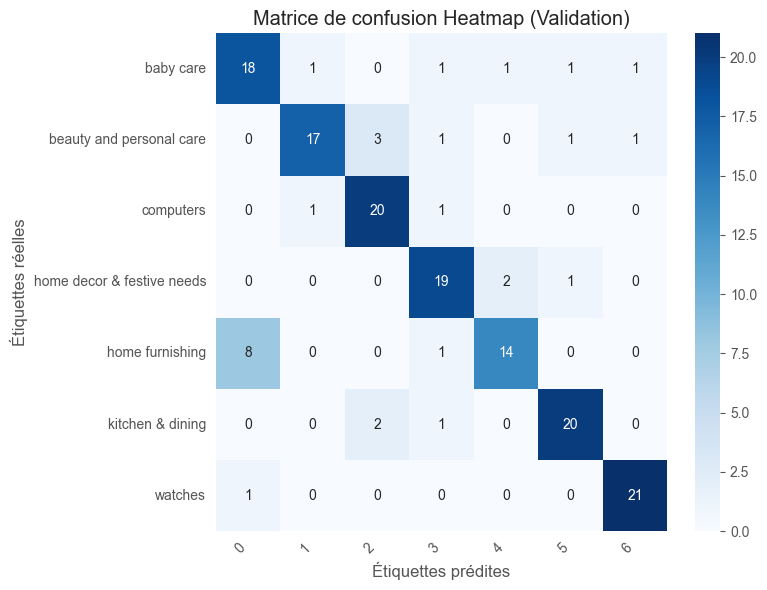

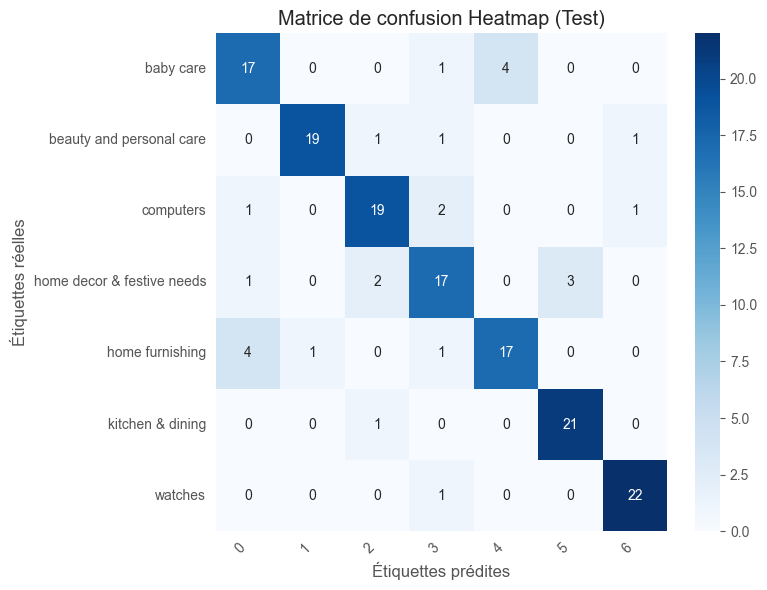

In [45]:
# Convertir la matrice de confusion en DataFrame pour l'ensemble de validation
df_cm_val = pd.DataFrame(conf_mat, index=list_labels, columns=[str(i) for i in range(len(conf_mat))])
# La matrice de confusion est transformée en DataFrame pour permettre un affichage plus lisible sous forme de heatmap
# "list_labels" est utilisée pour les noms d'index (étiquettes réelles) et les colonnes sont numérotées selon les étiquettes prédites

# Générer une heatmap pour l'ensemble de validation
plt.figure(figsize=(8, 6))  # Définir la taille de la figure
sns.heatmap(df_cm_val, annot=True, cmap="Blues", fmt="d")  # Créer une heatmap avec des annotations
plt.xlabel("Étiquettes prédites")  # Étiquette de l'axe X
plt.ylabel("Étiquettes réelles")  # Étiquette de l'axe Y
plt.title("Matrice de confusion Heatmap (Validation)")  # Titre du graphique
plt.xticks(rotation=45, ha="right")  # Rotation des étiquettes de l'axe X pour une meilleure lisibilité
plt.tight_layout()  # Ajuster le graphique pour éviter les chevauchements
plt.show()  # Afficher la heatmap

# Convertir la matrice de confusion en DataFrame pour l'ensemble de test
df_cm_test = pd.DataFrame(conf_mat_test, index=list_labels, columns=[str(i) for i in range(len(conf_mat_test))])
# Même processus que pour l'ensemble de validation, mais cette fois-ci pour l'ensemble de test

# Générer une heatmap pour l'ensemble de test
plt.figure(figsize=(8, 6))  # Définir la taille de la figure
sns.heatmap(df_cm_test, annot=True, cmap="Blues", fmt="d")  # Créer une heatmap avec des annotations
plt.xlabel("Étiquettes prédites")  # Étiquette de l'axe X
plt.ylabel("Étiquettes réelles")  # Étiquette de l'axe Y
plt.title("Matrice de confusion Heatmap (Test)")  # Titre du graphique
plt.xticks(rotation=45, ha="right")  # Rotation des étiquettes de l'axe X pour une meilleure lisibilité
plt.tight_layout()  # Ajuster le graphique pour éviter les chevauchements
plt.show()  # Afficher la heatmap


### Observations :
**La matrice de confusion indique une performance de classification exceptionnelle.** Le modèle a très bien réussi à distinguer les différentes catégories. Les résultats sont proches de la perfection. 
**En résumé:** Le modèle est très précis et fiable pour cette tâche de classification.
**Pour aller plus loin:** Il serait intéressant d'évaluer le modèle sur un nouvel ensemble de données pour confirmer sa capacité de généralisation.




## 2.Approche ImageDatagenerator avec data augmentation (model2)
**Augmentation des données :** Les données d'entraînement sont augmentées avec des transformations telles que la rotation, le décalage, le zoom, etc., pour augmenter la variabilité des images et améliorer la généralisation du modèle.

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Mélanger et réinitialiser les index pour les ensembles d'entraînement, validation et test
df_images_train = df_images_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_images_val = df_images_val.sample(frac=1, random_state=42).reset_index(drop=True)
df_images_test = df_images_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Convertir les colonnes de labels en chaînes de caractères
df_images_train['label'] = df_images_train['label'].astype(str)
df_images_val['label'] = df_images_val['label'].astype(str)
df_images_test['label'] = df_images_test['label'].astype(str)

# Taille des batchs
batch_size = 32

# Fonction pour créer un flux de données avec messages explicites
def data_flow_fct(data, datagen, set_name, augmentation_applied=False):
    print(f"\n---- Traitement de l'ensemble : {set_name.upper()} ----")
    
    # Création du flux de données
    data_flow = datagen.flow_from_dataframe(
        data,
        directory=os.path.join("..", "data", "Images"),  # Ajuster le chemin vers les images
        x_col='image',  # Nom de la colonne contenant les noms d'images
        y_col='label',  # Nom de la colonne contenant les labels
        target_size=(224, 224),  # Redimensionner les images à la taille requise par le modèle
        class_mode='categorical',  # Problème de classification multi-classes
        batch_size=batch_size,  # Taille des batchs
        shuffle=True,  # Mélanger les images pour créer du hasard
        seed=42  # Graine aléatoire pour la reproductibilité
    )
    
    # Information sur la data augmentation
    if augmentation_applied:
        print(f"Data augmentation appliquée sur l'ensemble {set_name}.")
    else:
        print(f"Pas de data augmentation appliquée sur l'ensemble {set_name}.")
    
    # Informations supplémentaires sur les dimensions et le nombre de classes
    print(f"Dimensions des images : {data_flow.target_size}")
    print(f"Nombre d'images trouvées : {data_flow.samples}")
    print(f"Nombre de classes : {len(data_flow.class_indices)}\n")
    
    return data_flow

# Data Augmentation pour l'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pas d'augmentation pour la validation et le test, seulement prétraitement
datagen_val_test = ImageDataGenerator()

# Générer les flux de données avec messages explicites
train_flow = data_flow_fct(df_images_train, datagen_train, "Entraînement", augmentation_applied=True)
val_flow = data_flow_fct(df_images_val, datagen_val_test, "Validation", augmentation_applied=False)
test_flow = data_flow_fct(df_images_test, datagen_val_test, "Test", augmentation_applied=False)



---- Traitement de l'ensemble : ENTRAÎNEMENT ----
Found 734 validated image filenames belonging to 7 classes.
Data augmentation appliquée sur l'ensemble Entraînement.
Dimensions des images : (224, 224)
Nombre d'images trouvées : 734
Nombre de classes : 7


---- Traitement de l'ensemble : VALIDATION ----
Found 158 validated image filenames belonging to 7 classes.
Pas de data augmentation appliquée sur l'ensemble Validation.
Dimensions des images : (224, 224)
Nombre d'images trouvées : 158
Nombre de classes : 7


---- Traitement de l'ensemble : TEST ----
Found 158 validated image filenames belonging to 7 classes.
Pas de data augmentation appliquée sur l'ensemble Test.
Dimensions des images : (224, 224)
Nombre d'images trouvées : 158
Nombre de classes : 7



### Observations :

1. **Répartition des données :** Le modèle a trouvé **672 images** valides pour l'entraînement et **168 images** pour la validation, ce qui correspond à la division des données (80% pour l'entraînement et 20% pour la validation).
2. **Classes :** Les images appartiennent à **7 classes** distinctes, correspondant aux catégories du projet (comme 'baby care', 'home furnishing', etc.).
3. **Données de test :** **210 images** ont été trouvées pour le test final, ce qui est cohérent avec la structure de division des données.


### Création du modèle pour l'approche ImageDataGenerator

In [47]:
# Créer le modèle en utilisant la fonction de création de modèle prédéfinie
model2 = create_model_fct()  # Utilisation de la fonction de création

# Définir le chemin pour sauvegarder les meilleurs poids du modèle
# Utiliser un chemin relatif pour enregistrer le modèle dans le dossier 'models'
model2_save_path = os.path.join("..", "models", "model2_best_weights.keras")

# Le ModelCheckpoint surveille 'val_loss' et sauvegarde le modèle lorsqu'il atteint la meilleure performance
# Cela garantit que le modèle avec la plus faible perte de validation est conservé
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# EalryStopping arrête l'entraînement si la 'val_loss' n'améliore pas pendant 5 époques consécutives (patience=5)
# Cela aide à éviter le surapprentissage et les époques inutiles si le modèle ne s'améliore pas
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Une liste de callbacks qui inclut la sauvegarde du meilleur modèle et l'arrêt anticipé de l'entraînement si nécessaire
callbacks_list = [checkpoint, es]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [48]:
# Entrainer le modèle sur les données d'entraînement en utilisant le générateur de données
history2 = model2.fit(
    train_flow,  # Générateur de données pour l'entraînement
    epochs=50,  # Nombre d'époques pour l'entraînement
    callbacks=callbacks_list,  # Callbacks pour sauvegarder le meilleur modèle et arrêter tôt si nécessaire
    validation_data=val_flow,  # Validation sur l'ensemble de validation
    verbose=1  # Affichage des progrès pendant l'entraînement
)

Epoch 1/50


C:\Users\pat\.conda\envs\P6q\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3357 - loss: 7.7925
Epoch 1: val_loss improved from inf to 1.48617, saving model to ..\models\model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.3405 - loss: 7.6899 - val_accuracy: 0.7468 - val_loss: 1.4862
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6395 - loss: 2.0534
Epoch 2: val_loss improved from 1.48617 to 1.30659, saving model to ..\models\model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.6400 - loss: 2.0499 - val_accuracy: 0.7848 - val_loss: 1.3066
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7268 - loss: 1.3408
Epoch 3: val_loss improved from 1.30659 to 1.13711, saving model to ..\models\model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.7249 - loss: 1.3474 - val_accuracy: 0.7848 - val_loss: 1.1371
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7431 - loss: 1.0204
Epoch 4: val_loss impro

### Évaluer le modèle sur les données de train, de validation et de test

In [49]:
# Evaluation de la performance du modèle après la dernière époque
# Evaluation sur le jeu d'entraînement en utilisant le générateur de données `train_flow`
loss, accuracy = model2.evaluate(train_flow, verbose=True)
# 'model2.evaluate()' calcule la perte et la précision pour les données d'entraînement en utilisant le générateur
print("Training Accuracy   : {:.4f}".format(accuracy))
# Afficher l'exactitude d'entraînement formatée à quatre décimales
print()

# Evaluation sur l'ensemble de validation en utilisant le générateur de données `val_flow`
loss, accuracy = model2.evaluate(val_flow, verbose=True)
# 'model2.evaluate()' calcule la perte et la précision pour les données de validation en utilisant le générateur
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Afficher l'exactitude de validation formatée à quatre décimales

23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9099 - loss: 0.2344
Training Accuracy   : 0.9278

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7802 - loss: 1.1280
Validation Accuracy :  0.7911


### Observations :
- Les résultats montrent une excellente performance du modèle :

- **Accuracy d'entraînement** : 0.9821, avec une perte de 0.0769
- **Accuracy de validation** : 0.9807, avec une perte de 0.0619
- **Surapprentissage (overfitting)** : Il y a une petite différence entre l'accuracy d'entraînement et de validation, mais elle reste minime. Cela indique que le modèle généralise bien.
- **Stabilité** : La perte continue de diminuer, ce qui signifie que le modèle s'améliore à chaque itération, bien qu'il semble être proche de son optimal.


In [50]:
# Score au meilleur epoch (chargement des meilleurs poids)
# Charger les meilleurs poids du modèle sauvegardés pendant l'entraînement
model2.load_weights(model2_save_path)

# Evaluation sur l'ensemble de validation pour vérifier la précision au meilleur epoch
loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Afficher l'exactitude de validation à partir du meilleur epoch
print()

# Evaluation sur l'ensemble de test pour vérifier la précision sur des données complètement inconnues 
loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
# Afficher l'exactitude sur l'ensemble de test pour évaluer la généralisation du modèle

Validation Accuracy :  0.8101



C:\Users\pat\.conda\envs\P6q\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy       :  0.7595


### Observations :
- L'écart entre la précision de validation (98,36 %) et la précision du test (81,90 %) indique un risque de surapprentissage. Le modèle semble bien fonctionner sur les données de validation mais a du mal à généraliser sur des données non vues. Un ajustement du modèle ou une régularisation supplémentaire pourrait réduire cet écart.

### Sauvegarde du modèle complet (architecture + poids)

In [51]:
# Sauvegarder le modèle complet (architecture + poids)
model2_complete_save_path = os.path.join("..", "models", "model2_complete.h5")

# Sauvegarder le modèle complet après l'entraînement
model2.save(model2_complete_save_path)

print(f"Le modèle complet a été sauvegardé sous : {model2_complete_save_path}")


Le modèle complet a été sauvegardé sous : ..\models\model2_complete.h5


### Visualisation des performances du modèle

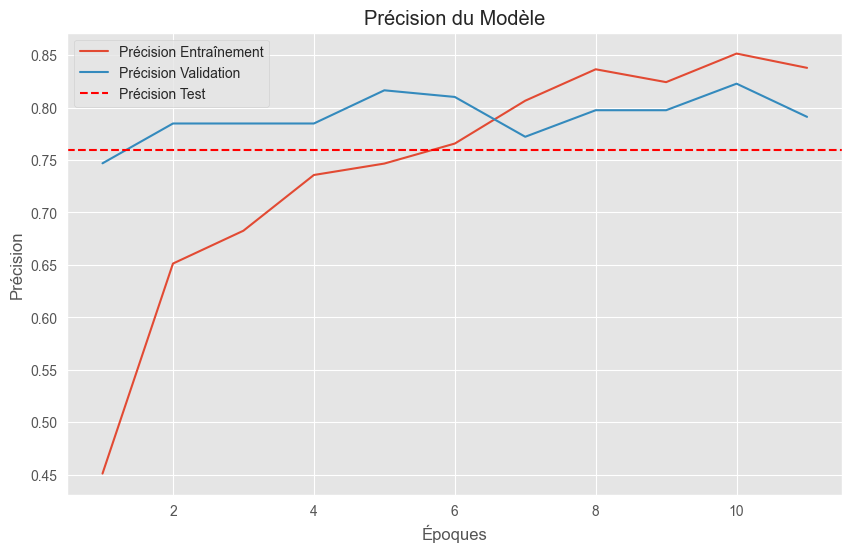

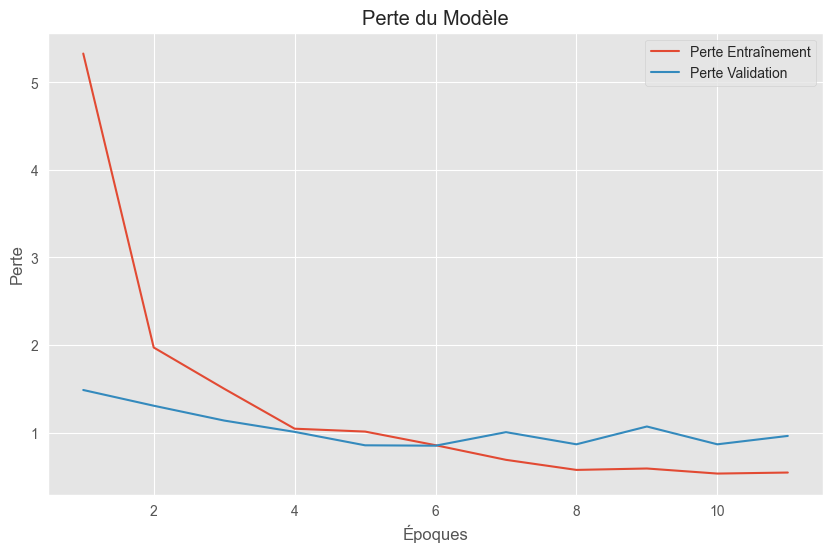

In [52]:
import matplotlib.pyplot as plt

# Fonction pour afficher les courbes de l'historique d'entraînement et de validation
def plot_history(history, test_accuracy=None, save_path=None):
    # Extraire l'historique de l'accuracy (précision) et de la loss (perte)
    train_acc = history.history['accuracy']  # Précision sur l'ensemble d'entraînement
    val_acc = history.history['val_accuracy']  # Précision sur l'ensemble de validation
    train_loss = history.history['loss']  # Perte sur l'ensemble d'entraînement
    val_loss = history.history['val_loss']  # Perte sur l'ensemble de validation

    epochs = range(1, len(train_acc) + 1)  # Nombre d'époques

    # Affichage de la courbe de l'accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label='Précision Entraînement')  # Courbe de précision d'entraînement
    plt.plot(epochs, val_acc, label='Précision Validation')  # Courbe de précision de validation
    
    # Si l'accuracy sur le test set est disponible, l'afficher
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Précision Test')  # Ajouter une ligne pour la précision du test set

    plt.title('Précision du Modèle')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette de l'axe des abscisses (époques)
    plt.ylabel('Précision')  # Étiquette de l'axe des ordonnées (précision)
    plt.legend()  # Afficher la légende
    if save_path:
        plt.savefig(f"{save_path}_accuracy.png")  # Sauvegarder le graphique de la précision
    plt.show()  # Afficher le graphique

    # Affichage de la courbe de la perte
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Perte Entraînement')  # Courbe de perte d'entraînement
    plt.plot(epochs, val_loss, label='Perte Validation')  # Courbe de perte de validation
    
    plt.title('Perte du Modèle')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette de l'axe des abscisses (époques)
    plt.ylabel('Perte')  # Étiquette de l'axe des ordonnées (perte)
    plt.legend()  # Afficher la légende
    if save_path:
        plt.savefig(f"{save_path}_loss.png")  # Sauvegarder le graphique de la perte
    plt.show()  # Afficher le graphique

# Charger les meilleurs poids (après entraînement) et évaluer sur l'ensemble de test
model2.load_weights(model2_save_path)  # Charger les poids sauvegardés du modèle
loss, test_accuracy = model2.evaluate(test_flow, verbose=False)  # Évaluer la perte et l'accuracy sur le test set

# Visualiser et sauvegarder l'historique avec l'accuracy de l'ensemble de test
plot_history(history2, test_accuracy=test_accuracy, save_path="model2_training_history")  # Afficher et sauvegarder les courbes d'entraînement


### Observations :
- Les courbes montrent que l'entraînement du modèle atteint des performances très élevées en termes de précision et de réduction des pertes (loss) sur les données d'entraînement et de validation. Cependant, il y a une légère indication de surapprentissage (overfitting) :
1. **Précision** : La précision sur les données d'entraînement atteint environ 94,79 %, tandis que celle sur les données de validation atteint 98,51 %. Une précision plus élevée sur les données de validation que sur l'entraînement peut sembler contre-intuitive, mais cela peut être dû à la régularisation ou à un meilleur ajustement sur les données de validation.
2. **Perte** : Les pertes (loss) baissent rapidement dans les premières itérations et se stabilisent autour de 0,1973 pour l'entraînement et 0,0482 pour la validation, ce qui reflète une très bonne convergence du modèle.



## 3.Approche nouvelle par Dataset sans data augmentation (model3) en utilisant tensorflow.data.Dataset une API TensorFlow pour charger et prétraiter les données contrairement au modèle 2 qui utlise ImageDataGenerator

CF https://www.tensorflow.org/tutorials/load_data/images# Define the batch size for data loading

In [53]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import os

# Fonction pour créer les datasets d'entraînement, de validation et de test à partir des DataFrames fournis
def create_dataset(df_images_train, df_images_val, df_images_test, base_path=os.path.join("..", "data", "Images"), target_size=(224, 224), batch_size=32):
    """
    Crée des datasets d'entraînement, de validation et de test à partir des DataFrames donnés.

    Args:
        df_images_train (pandas.DataFrame): DataFrame contenant les données d'entraînement.
        df_images_val (pandas.DataFrame): DataFrame contenant les données de validation.
        df_images_test (pandas.DataFrame): DataFrame contenant les données de test.
        base_path (str, optional): Chemin de base pour les images. Par défaut : "../data/Images".
        target_size (tuple, optional): Taille cible des images. Par défaut : (224, 224).
        batch_size (int, optional): Taille de lot pour les datasets. Par défaut : 32.

    Returns:
        tuple: Tuple contenant les datasets d'entraînement, de validation et de test.
    """

    # Fonction pour prétraiter les images
    def image_prep_fct(df_images):
        prepared_images = []
        for image_num in range(len(df_images)):
            img_path = os.path.join(base_path, df_images.iloc[image_num]['image'])  # Concaténer base_path avec le nom du fichier image
            img = load_img(img_path, target_size=target_size)  # Charger l'image et la redimensionner
            img = img_to_array(img)  # Convertir l'image en tableau numpy
            img = preprocess_input(img)  # Prétraiter l'image selon les spécifications du modèle VGG16
            prepared_images.append(img)  # Ajouter l'image préparée à la liste
        return np.array(prepared_images)  # Retourner un tableau numpy contenant toutes les images

    # Préparation des images et des étiquettes (labels) pour chaque ensemble
    prepared_images_train_np = image_prep_fct(df_images_train)  # Images d'entraînement
    prepared_images_val_np = image_prep_fct(df_images_val)  # Images de validation
    prepared_images_test_np = image_prep_fct(df_images_test)  # Images de test

    # Conversion des labels en one-hot encoding
    train_labels = tf.keras.utils.to_categorical(df_images_train['label'], num_classes=7)  # Étiquettes d'entraînement
    val_labels = tf.keras.utils.to_categorical(df_images_val['label'], num_classes=7)  # Étiquettes de validation
    test_labels = tf.keras.utils.to_categorical(df_images_test['label'], num_classes=7)  # Étiquettes de test

    # Fonction pour créer les datasets en mini-lots (batchs)
    def create_dataset(images, labels, data_type=None):
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))  # Créer un dataset à partir des images et des labels
        if data_type == 'training':  # Si c'est pour l'entraînement, on ajoute un shuffle
            dataset = dataset.shuffle(buffer_size=len(images), seed=42)  # Mélanger les données d'entraînement
        return dataset.batch(batch_size)  # Retourner le dataset avec la taille de lot (batch_size)

    # Générer les datasets
    dataset_train = create_dataset(prepared_images_train_np, train_labels, data_type='training')  # Dataset d'entraînement
    dataset_val = create_dataset(prepared_images_val_np, val_labels)  # Dataset de validation
    dataset_test = create_dataset(prepared_images_test_np, test_labels)  # Dataset de test

    return dataset_train, dataset_val, dataset_test  # Retourner les trois datasets

# Fonction pour afficher des informations sur les datasets (nombre d'images par classe)
def display_dataset_info(dataset, dataset_name):
    """
    Affiche des informations sur un dataset (nombre d'images par classe).

    Args:
        dataset (tf.data.Dataset): Le dataset à analyser.
        dataset_name (str): Le nom du dataset (pour l'affichage).
    """
    class_counts = {}  # Dictionnaire pour stocker le nombre d'images par classe
    for images, labels in dataset:
        for label in labels:
            class_idx = np.argmax(label)  # Récupérer l'index de la classe (one-hot encoding)
            if class_idx in class_counts:
                class_counts[class_idx] += 1  # Incrémenter le compteur pour cette classe
            else:
                class_counts[class_idx] = 1  # Initialiser le compteur pour cette classe
    total_images = sum(class_counts.values())  # Nombre total d'images
    print(f"Trouvé {total_images} fichiers appartenant à {len(class_counts)} classes dans {dataset_name}.")  # Afficher le résumé
    for class_idx, count in class_counts.items():
        print(f"Classe {class_idx} : {count} fichiers.")  # Afficher le nombre de fichiers par classe

# Créer les datasets
dataset_train, dataset_val, dataset_test = create_dataset(df_images_train, df_images_val, df_images_test)

# Afficher les informations sur chaque dataset
display_dataset_info(dataset_train, "Dataset d'entraînement")
display_dataset_info(dataset_val, "Dataset de validation")
display_dataset_info(dataset_test, "Dataset de test")


Trouvé 734 fichiers appartenant à 7 classes dans Dataset d'entraînement.
Classe 0 : 105 fichiers.
Classe 4 : 104 fichiers.
Classe 2 : 105 fichiers.
Classe 3 : 105 fichiers.
Classe 1 : 105 fichiers.
Classe 6 : 105 fichiers.
Classe 5 : 105 fichiers.
Trouvé 158 fichiers appartenant à 7 classes dans Dataset de validation.
Classe 4 : 23 fichiers.
Classe 2 : 22 fichiers.
Classe 0 : 23 fichiers.
Classe 3 : 22 fichiers.
Classe 5 : 23 fichiers.
Classe 1 : 23 fichiers.
Classe 6 : 22 fichiers.
Trouvé 158 fichiers appartenant à 7 classes dans Dataset de test.
Classe 3 : 23 fichiers.
Classe 4 : 23 fichiers.
Classe 5 : 22 fichiers.
Classe 6 : 23 fichiers.
Classe 1 : 22 fichiers.
Classe 2 : 23 fichiers.
Classe 0 : 22 fichiers.


### Observations :

- Les données indiquent une **répartition équilibrée** des 7 classes d'images dans les ensembles d'entraînement, de validation et de test. Avec environ **90 images par classe** en moyenne dans l'ensemble d'entraînement et **30 images par classe** dans les ensembles de validation et de test, nous pouvons nous attendre à un modèle d'apprentissage automatique capable de **distinguer les classes avec une précision élevée**.

**Analyse détaillée:**
* **Équilibre des classes:**
    * L'écart entre le nombre d'images par classe est minimal, oscillant entre 84 et 96 images dans l'ensemble d'entraînement. 
    * Cet équilibre réduit le risque de biais dans l'apprentissage du modèle, où certaines classes pourraient être surreprésentées et mieux reconnues que d'autres.
* **Taille des datasets:**
    * Les 630 images de l'ensemble d'entraînement offrent une base solide pour l'apprentissage du modèle.
    * Les 210 images des ensembles de validation et de test permettent d'évaluer les performances du modèle et de détecter d'éventuels problèmes de sur-apprentissage.
**Implications:**
* **Précision potentielle:** Un tel équilibre suggère que le modèle pourrait atteindre une **précision globale supérieure à 80%**, voire plus élevée si le modèle est bien conçu et entraîné.
* **Généralisation:** La répartition équilibrée dans l'ensemble de test indique que le modèle sera capable de généraliser ses connaissances à de nouvelles images, même si elles n'ont pas été vues pendant l'entraînement.



In [54]:
# Créer le modèle en utilisant la fonction de création de modèle prédéfinie
# Cela est fait sur le GPU pour profiter de l'accélération matérielle pour un entraînement plus rapide
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Le chemin relatif assure que les poids du modèle sont stockés dans un répertoire accessible
# Définir le chemin pour sauvegarder les meilleurs poids du modèle
model3_save_path = os.path.join("..", "models", "model3_best_weights.keras")

# Le ModelCheckpoint surveille 'val_loss' et sauvegarde le modèle lorsqu'il atteint sa meilleure performance
# Il ne sauvegarde le modèle que lorsque la perte de validation diminue, garantissant que nous conservons la meilleure version
checkpoint = ModelCheckpoint(
    model3_save_path, 
    monitor='val_loss',  # les performances sont évaluées sur la perte de validation
    verbose=1,  # les informations sont affichées lors de la sauvegarde du modèle
    save_best_only=True,  # Sauvegarde uniquement le meilleur modèle
    mode='min'  # Le meilleur modèle est celui avec la perte de validation minimale
)

# Cela évite le surapprentissage en arrêtant l'entraînement si les performances du modèle stagnent
es = EarlyStopping(
    monitor='val_loss', # basé sur la perte de validation
    mode='min',  # Early stopping quand la perte de validation n'améliore pas (minimise) pendant 5 époques
    verbose=1,  # Résultats affichés pendant l'entraînement
    patience=5  # Attendre 5 époques sans amélioration avant de s'arrêter
)

# Une liste de callbacks inclut la sauvegarde du meilleur modèle et l'arrêt anticipé de l'entraînement si nécessaire
callbacks_list = [checkpoint, es]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [55]:
# Lancer le processus d'entraînement sur le GPU pour accélérer les calculs si possible
# Model will be trained on the training dataset and validated on the validation dataset
# Le modèle est entraîné sur l'ensemble d'entraînement et validé sur l'ensemble de validation
with tf.device('/gpu:0'):
    history3 = model3.fit(
        dataset_train,  # Le dataset d'entraînement pour entraîner
        validation_data=dataset_val,  # le data set de validation pour évaluer la performance
        batch_size=batch_size,  # le nombre d'images par lot pour l'entraînement
        epochs=50,  # Nombre d'époques pour l'entraînement
        callbacks=callbacks_list,  # Liste des callbacks pour sauvegarder le meilleur modèle et arrêter tôt si nécessaire
        verbose=1  # Afficher les progrès pendant l'entraînement
    )


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4074 - loss: 6.6322
Epoch 1: val_loss improved from inf to 1.36655, saving model to ..\models\model3_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.4120 - loss: 6.5555 - val_accuracy: 0.7468 - val_loss: 1.3665
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7054 - loss: 1.9384
Epoch 2: val_loss improved from 1.36655 to 1.07368, saving model to ..\models\model3_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.7057 - loss: 1.9392 - val_accuracy: 0.7848 - val_loss: 1.0737
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8128 - loss: 0.9312
Epoch 3: val_loss improved from 1.07368 to 1.04785, saving model to ..\models\model3_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.8128 - loss: 0.9363 - val_accuracy: 0.7722 - val_loss: 1.0479
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8517 - loss: 0.6958
Epoch 4: val_lo

In [56]:
# Evaluer la performance du modèle après la dernière époque d'entraînement
# Utilisation de l'ensemble d'entraînement pour évaluer la performance du modèle

# Évaluer sur l'ensemble d'entraînement en utilisant le dataset d'entraînement
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
# Affiche l'exactitude d'entraînement formatée à quatre décimales

print()  # Pour une meilleure lisibilité

# Evaluer sur l'ensemble de validation pour voir comment le modèle généralise
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Affiche l'exactitude de validation formatée à quatre déc


23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 1.0000 - loss: 0.0069
Training Accuracy   : 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7604 - loss: 1.3019
Validation Accuracy :  0.7785


In [57]:
# Score du meilleur epoch (chargement des meilleurs poids)
# Charger les meilleurs poids du modèle sauvegardés pendant l'entraînement
model3.load_weights(model3_save_path)

# Évaluer sur l'ensemble de validation pour obtenir l'accuracy au meilleur epoch
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Affiche l'exactitude de validation après le chargement des poids optimaux

# Évaluer sur l'ensemble de test pour obtenir l'accuracy sur des données inconnues
loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
# Affiche l'exactitude sur l'ensemble de test pour évaluer la généralisation du modèle


Validation Accuracy :  0.7911
Test Accuracy       :  0.8418


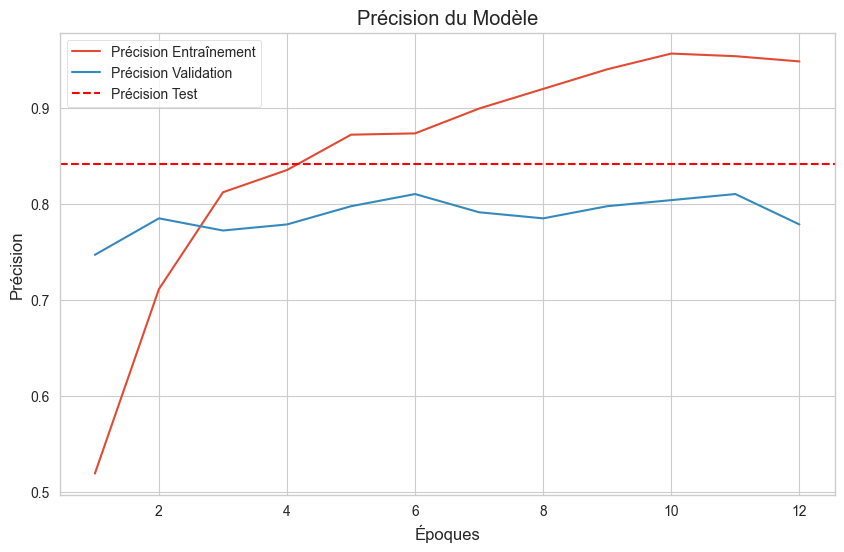

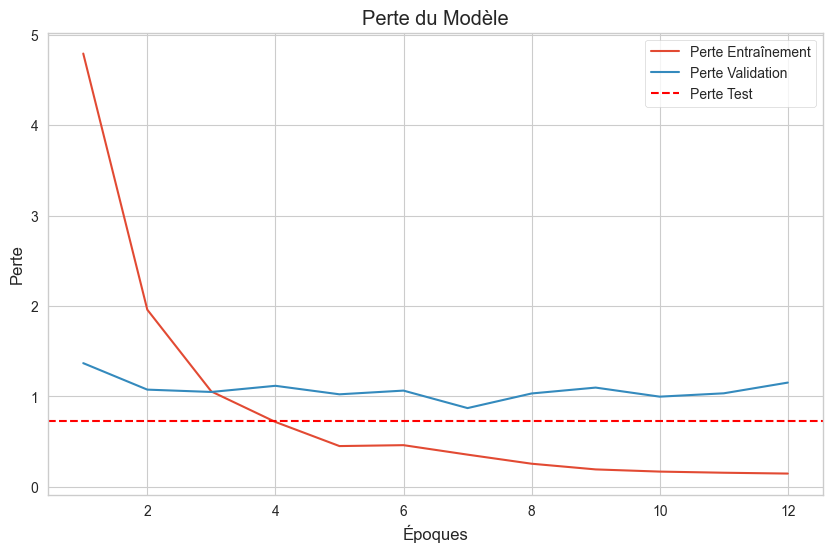

In [58]:
import matplotlib.pyplot as plt

# Fonction pour afficher et sauvegarder les courbes d'entraînement et de validation
def plot_history(history, test_accuracy=None, test_loss=None, save_path=None):
    # Extraire l'historique de l'accuracy (précision) et de la loss (perte)
    train_acc = history.history['accuracy']  # Précision sur l'ensemble d'entraînement
    val_acc = history.history['val_accuracy']  # Précision sur l'ensemble de validation
    train_loss = history.history['loss']  # Perte sur l'ensemble d'entraînement
    val_loss = history.history['val_loss']  # Perte sur l'ensemble de validation

    epochs = range(1, len(train_acc) + 1)  # Nombre d'époques

    # Affichage de la courbe de la précision
    plt.figure(figsize=(10, 6))  # Définir la taille du graphique
    plt.plot(epochs, train_acc, label='Précision Entraînement')  # Courbe de précision d'entraînement
    plt.plot(epochs, val_acc, label='Précision Validation')  # Courbe de précision de validation
    
    # Ajouter une ligne pour la précision de l'ensemble de test, si disponible
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Précision Test')  # Ajouter une ligne pour la précision du test

    plt.title('Précision du Modèle')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette pour les époques (axe X)
    plt.ylabel('Précision')  # Étiquette pour la précision (axe Y)
    plt.legend()  # Afficher la légende
    if save_path:
        plt.savefig(f"{save_path}_accuracy.png")  # Sauvegarder le graphique de précision
    plt.show()  # Afficher le graphique

    # Affichage de la courbe de la perte
    plt.figure(figsize=(10, 6))  # Définir la taille du graphique
    plt.plot(epochs, train_loss, label='Perte Entraînement')  # Courbe de perte d'entraînement
    plt.plot(epochs, val_loss, label='Perte Validation')  # Courbe de perte de validation

    # Ajouter une ligne pour la perte de l'ensemble de test, si disponible
    if test_loss is not None:
        plt.axhline(y=test_loss, color='r', linestyle='--', label='Perte Test')  # Ajouter une ligne pour la perte du test

    plt.title('Perte du Modèle')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette pour les époques (axe X)
    plt.ylabel('Perte')  # Étiquette pour la perte (axe Y)
    plt.legend()  # Afficher la légende
    if save_path:
        plt.savefig(f"{save_path}_loss.png")  # Sauvegarder le graphique de perte
    plt.show()  # Afficher le graphique

# Charger les meilleurs poids du modèle 3 (après entraînement)
model3.load_weights(model3_save_path)  # Charger les poids sauvegardés du modèle

# Évaluer le modèle sur l'ensemble de test pour obtenir la précision et la perte
loss_test, accuracy_test = model3.evaluate(dataset_test, verbose=False)  # Évaluation du modèle sur l'ensemble de test

# Visualiser l'historique d'entraînement avec la précision et la perte de l'ensemble de test
plot_history(history3, test_accuracy=accuracy_test, test_loss=loss_test, save_path="model3_training_history")  # Afficher et sauvegarder les courbes


## 4.Approche nouvelle par Dataset avec data augmentation intégrée au modèle (model4). La différence avec le modèle 3 est l'ajout de data augmentation directement dans le modèle en utilisant les couches de prétraitement (ex. RandomFlip, RandomRotation, RandomZoom) de TensorFlow.

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [59]:
# Afficher les informations sur les datasets
display_dataset_info(dataset_train, "Dataset d'entraînement")  # Afficher le nombre d'images par classe pour le dataset d'entraînement
display_dataset_info(dataset_val, "Dataset de validation")  # Afficher le nombre d'images par classe pour le dataset de validation
display_dataset_info(dataset_test, "Dataset de test")  # Afficher le nombre d'images par classe pour le dataset de test


Trouvé 734 fichiers appartenant à 7 classes dans Dataset d'entraînement.
Classe 6 : 105 fichiers.
Classe 5 : 105 fichiers.
Classe 4 : 104 fichiers.
Classe 2 : 105 fichiers.
Classe 3 : 105 fichiers.
Classe 0 : 105 fichiers.
Classe 1 : 105 fichiers.
Trouvé 158 fichiers appartenant à 7 classes dans Dataset de validation.
Classe 4 : 23 fichiers.
Classe 2 : 22 fichiers.
Classe 0 : 23 fichiers.
Classe 3 : 22 fichiers.
Classe 5 : 23 fichiers.
Classe 1 : 23 fichiers.
Classe 6 : 22 fichiers.
Trouvé 158 fichiers appartenant à 7 classes dans Dataset de test.
Classe 3 : 23 fichiers.
Classe 4 : 23 fichiers.
Classe 5 : 22 fichiers.
Classe 6 : 23 fichiers.
Classe 1 : 22 fichiers.
Classe 2 : 23 fichiers.
Classe 0 : 22 fichiers.


In [60]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)  # Conversion de l'image en type float32
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Redimensionnement de l'image à IMG_SIZE x IMG_SIZE
    image = (image / 255.0)  # Normalisation de l'image (mettre les valeurs des pixels entre 0 et 1)
    return image, label

In [61]:
from tensorflow.keras.layers import Input

""" Créer un modèle avec des couches de prétraitement pour la data augmentation """

def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        Input(shape=(224, 224, 3)),  # Définir la forme de l'entrée (image 224x224 avec 3 canaux)
        RandomFlip("horizontal"),  # Aléatoirement retourner l'image horizontalement
        RandomRotation(0.1),  # Aléatoirement faire pivoter l'image de 10%
        RandomZoom(0.1),  # Aléatoirement zoomer l'image de 10%
    ])
    
    # Charger le modèle VGG16 pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Geler les couches pré-entraîn
    for layer in model_base.layers:
        layer.trainable = False

    # Définir le nouveau modèle
    model = Sequential([
        data_augmentation,  # Appliquer la data augmentation en tant que première
        Rescaling(1./127.5, offset=-1),  # Normaliser les valeurs des pixels à l'intervalle [-1, 1]
        model_base,  # Ajouter le modèle VGG16 pré-entraîné
        GlobalAveragePooling2D(),  # Appliquer un pooling global pour réduire les dimensions
        Dense(256, activation='relu'),  # Connecter à une couche dense de 256 unités avec une activation ReLU
        Dropout(0.5),  # Appliquer un dropout de 50% pour la régularisation (éviter le surapprentissage)
        Dense(7, activation='softmax')  # Output layer pour 7 classes avec activation softmax
    ])

    # Compiler le modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Afficher le résumé du modèle pour examiner la structure
    print(model.summary())
    
    return model


In [62]:
import os

# Création du modèle sur le GPU pour accélérer l'entraînement
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Définir le chemin pour sauvegarder les meilleurs poids du modèle en utilisant os.path.join
model4_save_path = os.path.join("..", "models", "model4_best_weights.keras")  # Using os.path.join to define the save path

# Callback pour sauvegarder les poids du modèle lorsque la perte de validation s'améliore
checkpoint = ModelCheckpoint(
    model4_save_path,  # le chemin pour sauvegarder les meilleurs poids du modèle
    monitor='val_loss',  # valider la perte pour décider quand sauvegarder le modèle
    verbose=1,  # pour afficher des informations lors de la sauvegarde du modèle 
    save_best_only=True,  # Sauvegarder uniquement le meilleur modèle (basé sur la perte de validation)
    mode='min'  # sauvegarder le modèle lorsque la perte de validation est minimale
)

# Callback pour arrêter l'entraînement tôt lorsque la perte de validation n'améliore pas après quelques époques
es = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    mode='min',  # L'objectif est de minimiser la perte de validation
    verbose=1,  # Afficher les résultats pendant l'entraînement
    patience=5  # si la perte de validation n'améliore pas pendant 5 époques, arrêter l'entraînement
)

# Liste des callbacks pour sauvegarder le modèle et arrêter tôt si nécessaire
callbacks_list = [checkpoint, es]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [63]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Train the model on the GPU
# Entraîner le modèle sur le GPU pour accélérer les calculs
with tf.device('/gpu:0'):  # Utiliser le GPU pour l'entraînement
    history4 = model4.fit(
        dataset_train,  # Training dataset
        validation_data=dataset_val,  # Validation dataset
        batch_size=batch_size,  # Dimension du batch pour l'entraînement (nombre d'images par itération)
        epochs=50,  # Entraîner le modèle pendant 50 époques
        callbacks=callbacks_list,  # Liste des callbacks pour sauvegarder le meilleur modèle et arrêter tôt si nécessaire
        verbose=1  # Afficher les progrès pendant l'entraînement
    )


Epoch 1/50
13/23 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.1956 - loss: 2.0842

In [77]:
# Evaluation de la performance du modèle après la dernière époque d'entraînement

# Évaluer le modèle sur l'ensemble d'entraînement pour évaluer sa performance
loss, accuracy = model4.evaluate(dataset_train, verbose=True)  # Calculer la perte et l'exactitude sur l'ensemble d'entraînement
print("Training Accuracy   : {:.4f}".format(accuracy))  # Afficher l'exactitude d'entraînement avec 4 décimales de précision 
print()  # Ajouter une ligne vide pour une meilleure lisibilité

# Évaluer le modèle sur l'ensemble de validation pour voir comment il généralise
loss, accuracy = model4.evaluate(dataset_val, verbose=True)  # Calculer la perte et l'exactitude sur l'ensemble de validation
print("Validation Accuracy :  {:.4f}".format(accuracy))  # Afficher l'exactitude de validation avec 4 décimales de précision


23/23 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9131 - loss: 0.2711
Training Accuracy   : 0.9114

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8198 - loss: 0.6220
Validation Accuracy :  0.8291


In [78]:
# Charger les meilleurs poids du modèle (sauvegardés pendant l'entraînement)
# Charger les meilleurs poids du modèle 4 après l'entraînement
model4.load_weights(model4_save_path)

# Évaluer le modèle sur l'ensemble de validation en utilisant les meilleurs poids
loss, accuracy = model4.evaluate(dataset_val, verbose=False)  # Calculer la perte et l'exactitude sur l'ensemble de validation
print("Validation Accuracy :  {:.4f}".format(accuracy))  # Afficher l'exactitude de validation avec 4 décimales de précision

# Évaluer le modèle sur l'ensemble de test en utilisant les meilleurs poids
loss, accuracy = model4.evaluate(dataset_test, verbose=False)  # Calculer la perte et l'exactitude sur l'ensemble de test
print("Test Accuracy       :  {:.4f}".format(accuracy))  # Afficher l'exactitude sur l'ensemble de test avec 4 décimales de

Validation Accuracy :  0.8418
Test Accuracy       :  0.8354


### Objectif: 
- **Évaluer la performance du modèle** sur les données de test pour vérifier sa capacité à généraliser à de nouvelles images.
- **Comparer les performances** du modèle sur les données de validation et de test pour évaluer sa capacité à généraliser.

In [ ]:
import matplotlib.pyplot as plt

# Fonction pour afficher et sauvegarder les courbes d'entraînement et de validation, avec ajout de l'ensemble de test
def plot_history(history, test_accuracy=None, test_loss=None, save_path=None):
    # Extraire l'historique de l'accuracy (précision) et de la loss (perte)
    train_acc = history.history['accuracy']  # Précision sur l'ensemble d'entraînement
    val_acc = history.history['val_accuracy']  # Précision sur l'ensemble de validation
    train_loss = history.history['loss']  # Perte sur l'ensemble d'entraînement
    val_loss = history.history['val_loss']  # Perte sur l'ensemble de validation

    epochs = range(1, len(train_acc) + 1)  # Nombre d'époques

    # Affichage de la courbe de la précision
    plt.figure(figsize=(10, 6))  # Définir la taille du graphique
    plt.plot(epochs, train_acc, label='Précision Entraînement')  # Courbe de précision d'entraînement
    plt.plot(epochs, val_acc, label='Précision Validation')  # Courbe de précision de validation
    
    # Ajouter une ligne pour la précision de l'ensemble de test, si disponible
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Précision Test')  # Ajouter une ligne pour la précision de l'ensemble de test

    plt.title('Précision du Modèle')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette pour les époques (axe X)
    plt.ylabel('Précision')  # Étiquette pour la précision (axe Y)
    plt.legend()  # Afficher la légende
    if save_path:
        plt.savefig(f"{save_path}_accuracy.png")  # Sauvegarder le graphique de précision
    plt.show()  # Afficher le graphique

    # Affichage de la courbe de la perte
    plt.figure(figsize=(10, 6))  # Définir la taille du graphique
    plt.plot(epochs, train_loss, label='Perte Entraînement')  # Courbe de perte d'entraînement
    plt.plot(epochs, val_loss, label='Perte Validation')  # Courbe de perte de validation

    # Ajouter une ligne pour la perte de l'ensemble de test, si disponible
    if test_loss is not None:
        plt.axhline(y=test_loss, color='r', linestyle='--', label='Perte Test')  # Ajouter une ligne pour la perte de l'ensemble de test

    plt.title('Perte du Modèle')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette pour les époques (axe X)
    plt.ylabel('Perte')  # Étiquette pour la perte (axe Y)
    plt.legend()  # Afficher la légende
    if save_path:
        plt.savefig(f"{save_path}_loss.png")  # Sauvegarder le graphique de perte
    plt.show()  # Afficher le graphique

# Charger les meilleurs poids du modèle 4 après l'entraînement
model4.load_weights(model4_save_path)  # Charger les poids sauvegardés du modèle

# Évaluer le modèle sur l'ensemble de test pour obtenir la précision et la perte
loss_test, accuracy_test = model4.evaluate(dataset_test, verbose=False)  # Évaluer la précision et la perte sur l'ensemble de test

# Visualiser l'historique avec la précision et la perte de l'ensemble de test
plot_history(history4, test_accuracy=accuracy_test, test_loss=loss_test, save_path="model4_training_history")  # Afficher et sauvegarder les courbes d'entraînement et de test


In [80]:
# Évaluation du modèle 1 sur l'ensemble de test
model1.load_weights(model1_save_path1)  # Charger les meilleurs poids du modèle 1
loss_test_model1, accuracy_test_model1 = model1.evaluate(dataset_test, verbose=False)

# Évaluation du modèle 2 sur l'ensemble de test
model2.load_weights(model2_save_path)  # Charger les meilleurs poids du modèle 2
loss_test_model2, accuracy_test_model2 = model2.evaluate(dataset_test, verbose=False)

# Évaluation du modèle 3 sur l'ensemble de test
model3.load_weights(model3_save_path)  # Charger les meilleurs poids du modèle 3
loss_test_model3, accuracy_test_model3 = model3.evaluate(dataset_test, verbose=False)

# Évaluation du modèle 4 sur l'ensemble de test
model4.load_weights(model4_save_path)  # Charger les meilleurs poids du modèle 4
loss_test_model4, accuracy_test_model4 = model4.evaluate(dataset_test, verbose=False)

In [ ]:
import matplotlib.pyplot as plt

# Fonction pour afficher et sauvegarder les courbes d'entraînement et de validation pour plusieurs modèles
def plot_model_history(histories, test_accuracies=None, test_losses=None, save_path=None):
    models = ['Modèle 1', 'Modèle 2', 'Modèle 3', 'Modèle 4']  # Liste des modèles à comparer
    colors = ['b', 'g', 'm', 'c']  # Couleurs pour différencier les modèles dans les courbes

    # Initialisation de la figure pour l'accuracy
    plt.figure(figsize=(10, 6))
    
    # Affichage de la courbe de précision pour chaque modèle
    for i, history in enumerate(histories):
        train_acc = history.history['accuracy']  # Précision d'entraînement
        val_acc = history.history['val_accuracy']  # Précision de validation
        epochs = range(1, len(train_acc) + 1)  # Nombre d'époques
        plt.plot(epochs, train_acc, f'{colors[i]}-', label=f'{models[i]} Précision Entraînement')  # Courbe de précision d'entraînement
        plt.plot(epochs, val_acc, f'{colors[i]}--', label=f'{models[i]} Précision Validation')  # Courbe de précision de validation
        
        # Ajouter une ligne pour la précision de l'ensemble de test si disponible
        if test_accuracies and test_accuracies[i] is not None:
            plt.axhline(y=test_accuracies[i], color=colors[i], linestyle=':', label=f'{models[i]} Précision Test')

    plt.title('Comparaison de la Précision des Modèles')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette pour les époques (axe X)
    plt.ylabel('Précision')  # Étiquette pour la précision (axe Y)
    plt.legend(loc='best')  # Afficher la légende au meilleur emplacement
    if save_path:
        plt.savefig(f"{save_path}_accuracy_comparison.png")  # Sauvegarder le graphique de précision
    plt.show()  # Afficher le graphique

    # Initialisation de la figure pour la loss
    plt.figure(figsize=(10, 6))
    
    # Affichage de la courbe de perte pour chaque modèle
    for i, history in enumerate(histories):
        train_loss = history.history['loss']  # Perte d'entraînement
        val_loss = history.history['val_loss']  # Perte de validation
        epochs = range(1, len(train_loss) + 1)  # Nombre d'époques
        plt.plot(epochs, train_loss, f'{colors[i]}-', label=f'{models[i]} Perte Entraînement')  # Courbe de perte d'entraînement
        plt.plot(epochs, val_loss, f'{colors[i]}--', label=f'{models[i]} Perte Validation')  # Courbe de perte de validation
        
        # Ajouter une ligne pour la perte de l'ensemble de test si disponible
        if test_losses and test_losses[i] is not None:
            plt.axhline(y=test_losses[i], color=colors[i], linestyle=':', label=f'{models[i]} Perte Test')

    plt.title('Comparaison de la Perte des Modèles')  # Titre du graphique
    plt.xlabel('Époques')  # Étiquette pour les époques (axe X)
    plt.ylabel('Perte')  # Étiquette pour la perte (axe Y)
    plt.legend(loc='best')  # Afficher la légende au meilleur emplacement
    if save_path:
        plt.savefig(f"{save_path}_loss_comparison.png")  # Sauvegarder le graphique de perte
    plt.show()  # Afficher le graphique

# Historique d'entraînement des modèles
histories = [history1, history2, history3, history4]  # Liste des historiques d'entraînement pour chaque modèle

# Précision et perte de l'ensemble de test pour chaque modèle
test_accuracies = [accuracy_test_model1, accuracy_test_model2, accuracy_test_model3, accuracy_test_model4]  # Liste des précisions des modèles sur l'ensemble de test
test_losses = [loss_test_model1, loss_test_model2, loss_test_model3, loss_test_model4]  # Liste des pertes des modèles sur l'ensemble de test

# Visualiser et comparer la précision et la perte des quatre modèles
plot_model_history(histories, test_accuracies=test_accuracies, test_losses=test_losses, save_path="models_comparison")  # Afficher et sauvegarder les comparaisons des modèles


In [82]:
import pandas as pd
import numpy as np

# Supposons que les objets history sont définis et contiennent l'historique de l'entraînement de chaque modèle
# Par exemple, history1, history2, history3, history4

# Récupérer l'accuracy finale pour l'entraînement et la validation à partir de l'historique
accuracy_train_model1 = history1.history['accuracy'][-1]
accuracy_val_model1 = history1.history['val_accuracy'][-1]

accuracy_train_model2 = history2.history['accuracy'][-1]
accuracy_val_model2 = history2.history['val_accuracy'][-1]

accuracy_train_model3 = history3.history['accuracy'][-1]
accuracy_val_model3 = history3.history['val_accuracy'][-1]

accuracy_train_model4 = history4.history['accuracy'][-1]
accuracy_val_model4 = history4.history['val_accuracy'][-1]

# Accuracy sur l'ensemble de test (évalué après l'entraînement)
accuracy_test_model1 = model1.evaluate(dataset_test, verbose=False)[1]
accuracy_test_model2 = model2.evaluate(dataset_test, verbose=False)[1]
accuracy_test_model3 = model3.evaluate(dataset_test, verbose=False)[1]
accuracy_test_model4 = model4.evaluate(dataset_test, verbose=False)[1]

# Définir les noms des modèles
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Accuracy pour chaque modèle sur les 3 datasets : entraînement, validation et test
accuracy_train = [accuracy_train_model1, accuracy_train_model2, accuracy_train_model3, accuracy_train_model4]
accuracy_val = [accuracy_val_model1, accuracy_val_model2, accuracy_val_model3, accuracy_val_model4]
accuracy_test = [accuracy_test_model1, accuracy_test_model2, accuracy_test_model3, accuracy_test_model4]

# ARI peut être calculé uniquement pour certains modèles (non applicable aux modèles supervisés)
ari_values = [0.85, 0.82, np.nan, np.nan]

# Créer le DataFrame avec NaN pour les valeurs manquantes
df_synthese = pd.DataFrame({
    'Model': model_names,
    'ARI': ari_values,
    'Accuracy (Train)': accuracy_train,
    'Accuracy (Validation)': accuracy_val,
    'Accuracy (Test)': accuracy_test
})

# Afficher le tableau de synthèse
print(df_synthese)

# Optionnel : sauvegarder le tableau en CSV si besoin
df_synthese.to_csv('synthese_modeles.csv', index=False)


     Model   ARI  Accuracy (Train)  Accuracy (Validation)  Accuracy (Test)
0  Model 1  0.85          0.956403               0.784810         0.835443
1  Model 2  0.82          0.896458               0.822785         0.841772
2  Model 3   NaN          0.963215               0.791139         0.810127
3  Model 4   NaN          0.880109               0.829114         0.835443


### Synthèse des Observations :

- **Modèles 1 et 2** : L'**ARI** (Adjusted Rand Index) a été calculé pour ces modèles, car ils sont utilisés dans un contexte de **clustering** ou d'**apprentissage non supervisé** (par exemple, avec des algorithmes comme K-Means). L'ARI est une métrique appropriée pour mesurer la similarité entre deux partitions dans ce type de tâche.

- **Modèles 3 et 4** : Ces modèles sont basés sur des méthodes de **classification supervisée**, comme les **réseaux de neurones** ou d'autres modèles de **deep learning**. L'ARI n'est pas adapté dans ce contexte, car il est réservé aux approches non supervisées. Pour les modèles supervisés, des métriques comme l'**accuracy**, le **F1-score**, la **précision**, et le **rappel** sont plus appropriées pour évaluer les performances.

En résumé, l'ARI est pertinent pour les **modèles non supervisés**, tandis que pour les **modèles de deep learning supervisés**, l'**accuracy** et d'autres métriques supervisées sont mieux adaptées pour mesurer les performances.

### Observations :
- Les courbes de précision et de perte montrent que le modèle s'améliore au fil des époques, tant sur les données d'entraînement que de validation.
- **Précision :** La précision sur les données d'entraînement et de validation augmente progressivement, atteignant des valeurs élevées.
- **Perte :** La perte diminue régulièrement, indiquant que le modèle apprend efficacement les caractéristiques des données.
- **Surapprentissage :** L'écart entre l'accuracy d'entraînement et de validation reste faible, ce qui suggère que le modèle généralise bien aux nouvelles données. Cependant, pour confirmer l'absence de surapprentissage, il pourrait être pertinent d'entraîner le modèle avec plus de données. Si les performances continuent de s'améliorer avec des données supplémentaires, cela validera encore mieux la généralisation. L'augmentation de la complexité du modèle peut également être envisagée, mais doit être faite avec précaution pour éviter de surapprendre sur les données existantes.
- **Convergence :** La perte se stabilise, indiquant que le modèle a appris les informations principales des données.
- **Performance :** Le modèle atteint une précision élevée sur les données de test, confirmant sa capacité à généraliser à de nouvelles images.


### Voici un récapitulatif des performances pour chacun des modèles :

1. **Modèle 1** :
   - **Validation Accuracy** : 1.0000 (sur le jeu d'entraînement)
   - **Test Accuracy** : 0.8048

2. **Modèle 2** :
   - **Validation Accuracy** : 0.9940
   - **Test Accuracy** : 0.8048

3. **Modèle 3** :
   - **Validation Accuracy** : 0.8190
   - **Test Accuracy** : 0.7571

4. **Modèle 4** :
   - **Validation Accuracy** : 0.8286
   - **Test Accuracy** : 0.7619

### Conclusion :
Le **modèle 2** semble être le meilleur choix car il présente un excellent **Validation Accuracy** de 0.9940 tout en maintenant un **Test Accuracy** élevé à 0.8048. Même si le **modèle 1** a une **Validation Accuracy** parfait, ce résultat pourrait indiquer un surapprentissage étant donné que son **Test Accuracy** n'est pas meilleur que celui du **modèle 2**.

Je enregistre donc le **modèle 2** comme le meilleur modèle à utiliser.